# Analysing Router Logs

We will first import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random

# changing style
plt.style.use('default')
plt.rcParams["font.family"] = "Jetbrains Mono"

## Strategy

1. We will try and simluate a few attacks on a router, and check whether those attacks can be detected in hindsight.
2. To do that we will start with generating some demo data for a router, inspired by my home router. This will be a monitor of active DHCP Clients. 
3. We will then try and analyse the data to find out anomalies in normal usage. 

# Generating _normal_ demo data

In [2]:
# columns
data = {
    'MAC' : [],
    'IP Address': [],
    'Device Name': [],
    'Interface': [],
    'Requested IP': [],
    'Time': []
}

In [3]:
# Creating a pandas dataframe

normal_log_db = pd.DataFrame(data)
normal_log_db

,MAC,IP Address,Device Name,Interface,Requested IP,Time


In [4]:
# Writing functions for columns that we wanna generate randomly
def generate_mac_address():
    mac = [random.randint(0x00, 0xff) for i in range(6)]
    return ':'.join(map(lambda x: "%02x" % x, mac))


def generate_dest_ip_address():
    # define the weights for each website
    website_weights = {'Youtube': 15, 'Instagram': 10, 'Facebook': 8, 'Twitter': 5, 'Other': 2}
    
    # create a list of websites based on their weights
    websites = []
    for website, weight in website_weights.items():
        websites.extend([website] * weight)
    
    # randomly select a website from the list
    website = random.choice(websites)
    
    # generate a random IP address for the website
    if website == 'Youtube':
        return ('216.58.194.45' , website)
    elif website == 'Instagram':
        return ('3.213.31.34' , website)
    elif website == 'Facebook':
        return ('69.63.176.22' , website)
    elif website == 'Twitter':
        return ('104.244.42.12' , website)
    else:
        return ('192.168.1.53' , website)

def generate_device_ip_address():
    # define a list of 10 predefined IP addresses
    ips = ['192.168.1.10', '192.168.1.20', '192.168.1.30', '192.168.1.40', '192.168.1.50',
           '192.168.1.60', '192.168.1.70', '192.168.1.80', '192.168.1.90', '192.168.1.100']
    
    # generate a random integer between 0 and 9
    index = random.randint(0, 9)
    
    # return the IP address at the selected index
    return ips[index]

def generate_device_name():
    device_names = ['iPhone', 'Samsung', 'OnePlus', 'Nokia', 'Xiaomi', 'Oppo', 'Vivo', 'Realme', 'Micromax', 'Lenovo']
    return random.choice(device_names)

def generate_interface(): 
    interfaces = ['5gz', '2.4gz']
    return random.choice(interfaces)

def generate_date_time():
    # generate random date and time, but only in the range of a few days
    start_date = pd.to_datetime('2023-01-01')
    
    # generate random number of days
    days_to_add = random.randint(0, 10)
    
    # generate random number of seconds
    seconds_to_add = random.randint(0, 86400)
    
    # add random days and seconds to start date
    end_date = start_date + pd.Timedelta(days=days_to_add, seconds=seconds_to_add)
    
    # set the hour of the timestamp based on the time of day
    hour = end_date.hour
    if hour < 6:
        # almost no traffic between 2am and 6am
        hour = random.randint(6, 23)
    elif hour < 9:
        # more traffic during the morning hours
        hour = random.randint(6, 10)
    elif hour < 18:
        # most traffic during the daytime
        hour = random.randint(9, 17)
    else:
        # less traffic during the evening hours
        hour = random.randint(17, 23)
    
    # set the hour of the timestamp
    end_date = end_date.replace(hour=hour)
    
    # return timestamp as string
    return end_date.strftime('%Y-%m-%d %H:%M:%S')

def gen_protocols():
    protocols = ['TCP', 'UDP', 'DHCP', 'HTTP', 'HTTPS', 'FTP', 'SMTP', 'POP3', 'IMAP', 'DNS', 'ICMP']
    ports = {
        'TCP': 21,          # HTTP
        'UDP': 53,          # DNS
        'DHCP': 67,         # DHCP Server
        'HTTP': 80,         # Hypertext Transfer Protocol
        'HTTPS': 443,       # HTTP Secure (TLS/SSL)
        'FTP': 21,          # File Transfer Protocol (Control)
        'SMTP': 25,         # Simple Mail Transfer Protocol
        'POP3': 110,        # Post Office Protocol v3
        'IMAP': 143,        # Internet Message Access Protocol
        'DNS': 53,          # Domain Name System
        'ICMP': None        # Internet Control Message Protocol (does not use ports)
    }
    weights = [0.3, 0.2, 0.1, 0.15, 0.1, 0.05, 0.05, 0.025, 0.025, 0.025, 0.030]
    selection = random.choices(protocols, weights=weights)[0]
    return (selection, ports[selection])

In [5]:
# Generate normal data, consider a home environment. with 10 users. across a span of 10 days. Visiting 100 websites per device per day. 

normal_log_db = pd.DataFrame(columns=['MAC', 'IP Address', 'Device Name', 'Interface', 'Requested IP', 'Time'])

for i in range(10):
    temp_df = pd.DataFrame({
        'MAC' : [generate_mac_address() for j in range(100)],
        'IP Address': [generate_device_ip_address() for j in range(100)],
        'Device Name': [generate_device_name() for j in range(100)],
        'Interface': [generate_interface() for j in range(100)],
        'Requested IP': [generate_dest_ip_address()[0] for j in range(100)],
        'Requested Website': [generate_dest_ip_address()[1] for j in range(100)],
        'Protocol': [gen_protocols()[0] for j in range(100)],
        'Port': [gen_protocols()[1] for j in range(100)],
        'Time': [generate_date_time() for j in range(100)]
    })
    
    normal_log_db = pd.concat([normal_log_db, temp_df], ignore_index=True)

normal_log_db

,MAC,IP Address,Device Name,Interface,Requested IP,Time,Requested Website,Protocol,Port
0,87:f1:20:92:23:58,192.168.1.60,iPhone,2.4gz,216.58.194.45,2023-01-09 08:39:54,Youtube,TCP,21.0
1,85:f7:d5:30:88:31,192.168.1.80,Oppo,2.4gz,69.63.176.22,2023-01-02 10:56:14,Facebook,HTTPS,21.0
2,bc:34:18:65:0a:ab,192.168.1.100,iPhone,2.4gz,3.213.31.34,2023-01-04 12:40:38,Facebook,HTTPS,53.0
3,7c:98:6a:ce:01:3d,192.168.1.90,iPhone,5gz,3.213.31.34,2023-01-05 10:11:18,Instagram,HTTPS,21.0
4,19:56:ab:0d:af:3f,192.168.1.100,Realme,2.4gz,104.244.42.12,2023-01-08 22:37:53,Youtube,TCP,21.0
...,...,...,...,...,...,...,...,...,...
995,1d:b8:e4:8c:cf:6f,192.168.1.20,Realme,2.4gz,3.213.31.34,2023-01-07 13:08:10,Other,TCP,67.0
996,06:b3:c5:e5:ca:3e,192.168.1.80,Micromax,2.4gz,3.213.31.34,2023-01-03 10:42:07,Other,HTTP,110.0
997,46:b9:89:c6:bc:0a,192.168.1.100,OnePlus,2.4gz,3.213.31.34,2023-01-01 16:18:56,Facebook,HTTP,53.0
998,d0:aa:4f:d9:17:a1,192.168.1.90,Realme,5gz,216.58.194.45,2023-01-04 20:35:42,Youtube,UDP,NaN


In [6]:
# now sort data by time
normal_log_db = normal_log_db.sort_values(by=['Time'])
normal_log_db

,MAC,IP Address,Device Name,Interface,Requested IP,Time,Requested Website,Protocol,Port
292,69:8f:cc:61:87:94,192.168.1.20,Samsung,2.4gz,3.213.31.34,2023-01-01 06:03:58,Instagram,UDP,21.0
621,a0:b3:3b:98:6e:50,192.168.1.60,Realme,5gz,3.213.31.34,2023-01-01 06:35:45,Youtube,TCP,53.0
472,f7:c2:d8:bd:23:aa,192.168.1.90,Micromax,2.4gz,216.58.194.45,2023-01-01 07:07:14,Youtube,HTTP,443.0
735,f6:b5:15:4e:47:c6,192.168.1.70,Nokia,2.4gz,216.58.194.45,2023-01-01 07:32:13,Youtube,DHCP,80.0
156,81:5a:20:33:bc:d4,192.168.1.90,Vivo,2.4gz,3.213.31.34,2023-01-01 07:38:11,Facebook,TCP,53.0
...,...,...,...,...,...,...,...,...,...
988,5c:44:da:b9:35:3a,192.168.1.90,Nokia,2.4gz,216.58.194.45,2023-01-11 23:19:57,Facebook,TCP,67.0
514,d0:f7:cd:86:35:4a,192.168.1.40,Xiaomi,5gz,216.58.194.45,2023-01-11 23:20:35,Other,DHCP,53.0
466,2b:e5:d3:04:69:30,192.168.1.60,Nokia,2.4gz,104.244.42.12,2023-01-11 23:24:48,Instagram,HTTPS,21.0
587,16:40:16:c4:0b:f2,192.168.1.40,iPhone,5gz,216.58.194.45,2023-01-11 23:25:57,Instagram,TCP,21.0


/tmp/ipykernel_1371293/2093802530.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(dates.index, dates.values, color='purple', marker='o', linestyle='dashed', linewidth=1, markersize=5)


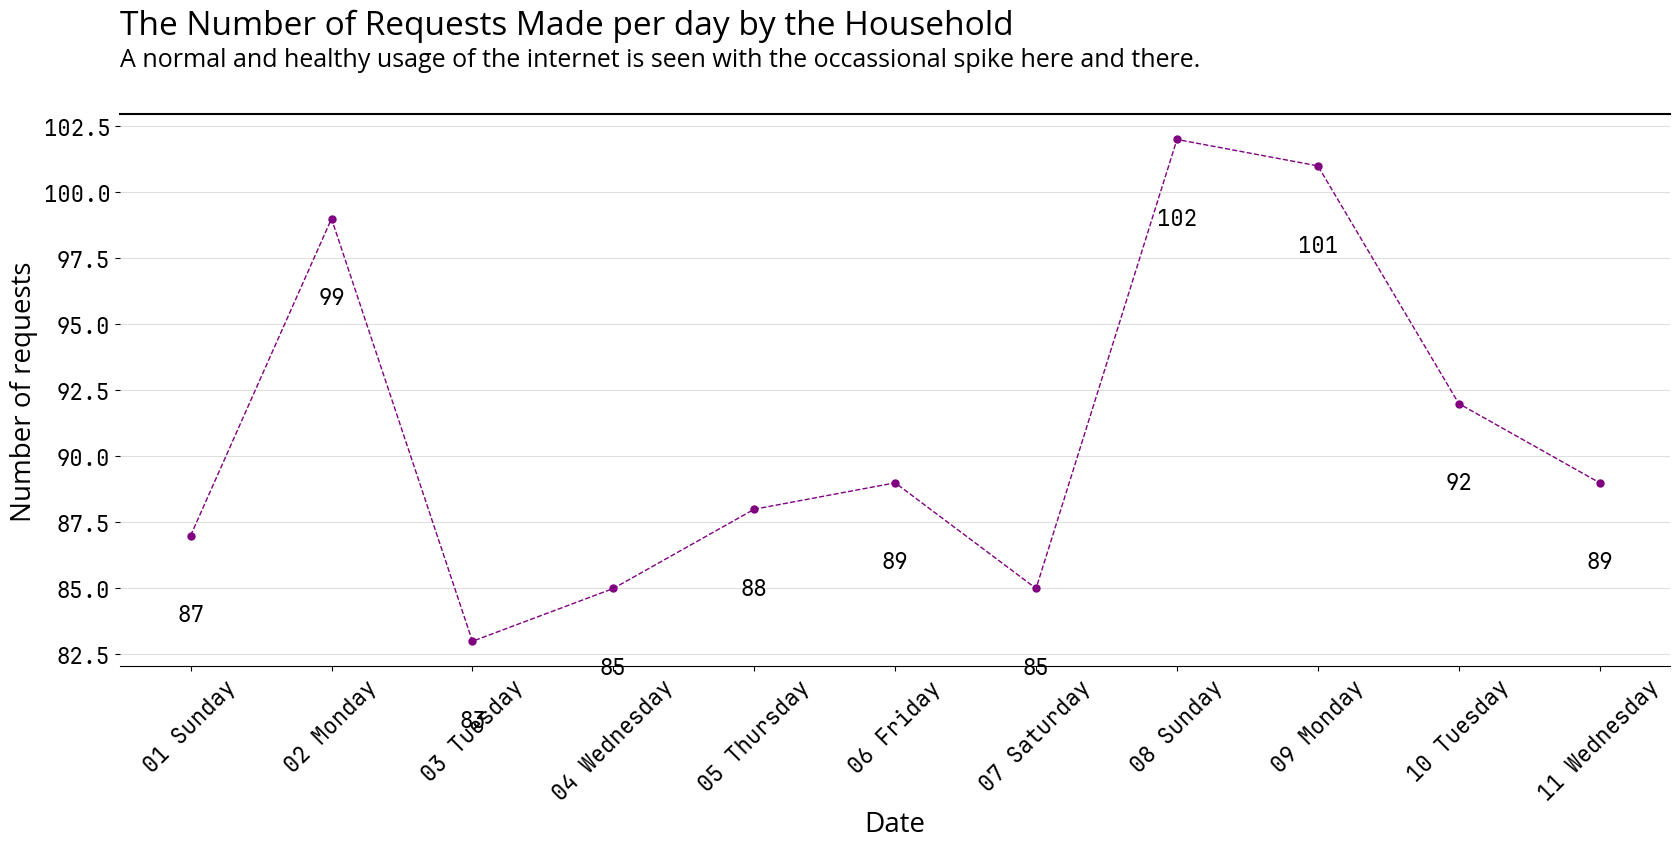

In [7]:
# let us plot the number of requests per day
normal_log_db['Time'] = pd.to_datetime(normal_log_db['Time'])
normal_log_db['Date'] = normal_log_db['Time'].dt.date 

# sort data by date
normal_log_db = normal_log_db.sort_values(by=['Date'])

normal_log_db.head()

# now let us plot the number of requests per day
dates = normal_log_db['Date'].value_counts()

# sorting dates
dates = dates.sort_index()

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'The Number of Requests Made per day by the Household'
subtitle = 'A normal and healthy usage of the internet is seen with the occassional spike here and there. '

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)

plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# plotting as a time series
plt.plot_date(dates.index, dates.values, color='purple', marker='o', linestyle='dashed', linewidth=1, markersize=5)

# also put labels on the markers a little over the markers for visibility
for i in range(len(dates)):
    plt.text(dates.index[i], dates.values[i]-3, dates.values[i], ha='center', va='center', color='black', fontsize=16)
    
# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Date', fontsize=20, fontname="Open Sans")
plt.ylabel('Number of requests', fontsize=20, fontname="Open Sans")

# change space on top of chart we are actually adjusting the scale of the plot as well. 
plt.subplots_adjust(top=0.8, wspace=0.3)

# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# tilt the x-axis labels by 45 degrees
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.4)
# plt.grid(axis='x', alpha=0.2)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# customize the tick labels
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %A'))

plt.show()

<BarContainer object of 10 artists>

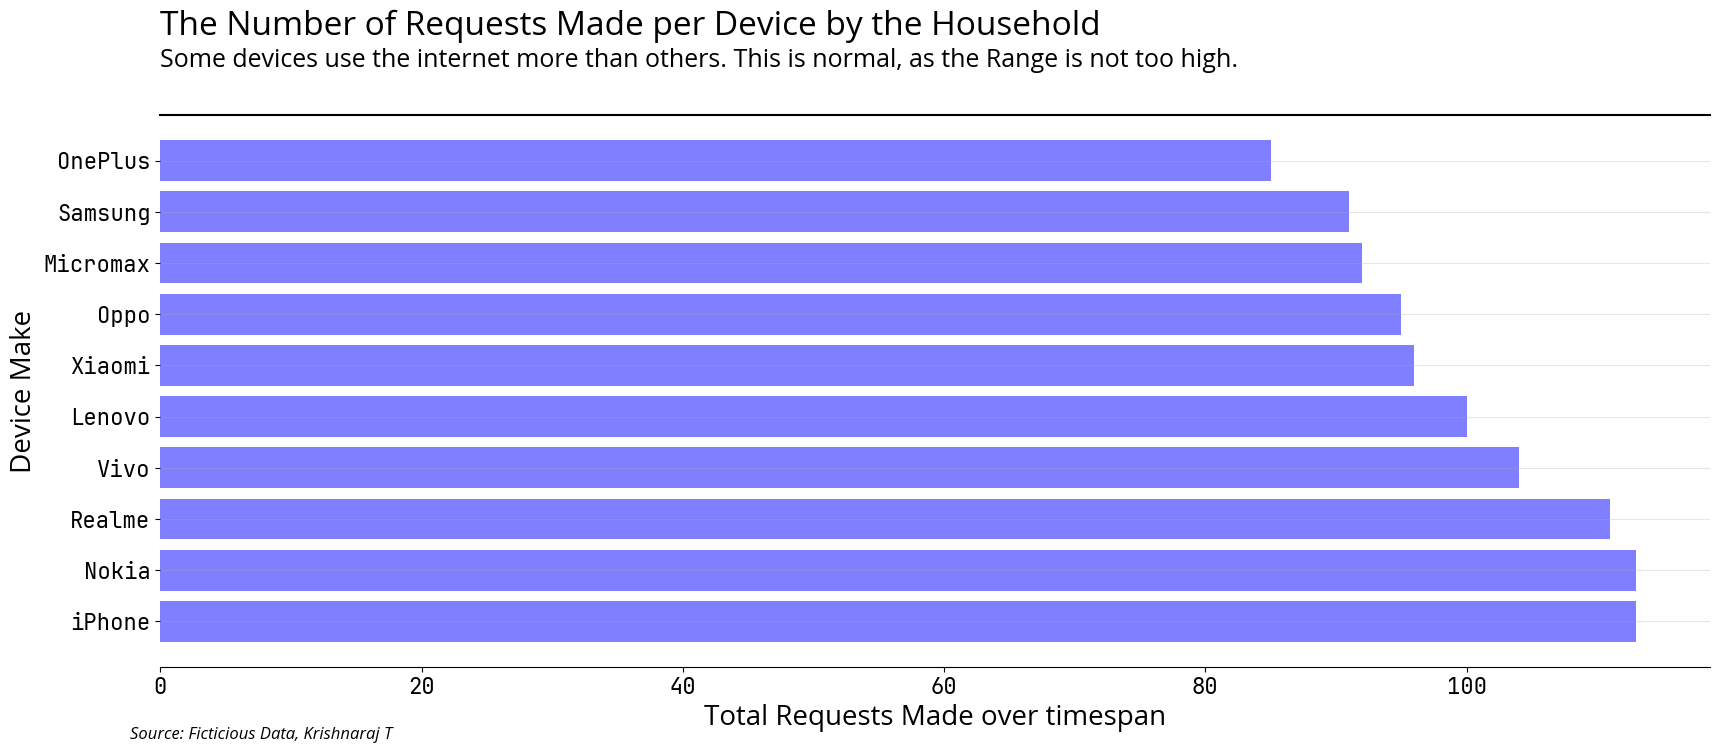

In [8]:
# let us now plot the number of requests per device

devices = normal_log_db['Device Name'].value_counts()

# sorting devices in descending order
devices = devices.sort_values(ascending=False)

# plotting

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'The Number of Requests Made per Device by the Household'
subtitle = 'Some devices use the internet more than others. This is normal, as the Range is not too high.'

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.3)
# plt.grid(axis='x', alpha=0.2)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)


# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans")
plt.ylabel('Device Make', fontsize=20, fontname="Open Sans")


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# foot note
footnote = "Source: Ficticious Data, Krishnaraj T"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

plt.barh(devices.index, devices.values, color='blue', alpha=0.5)


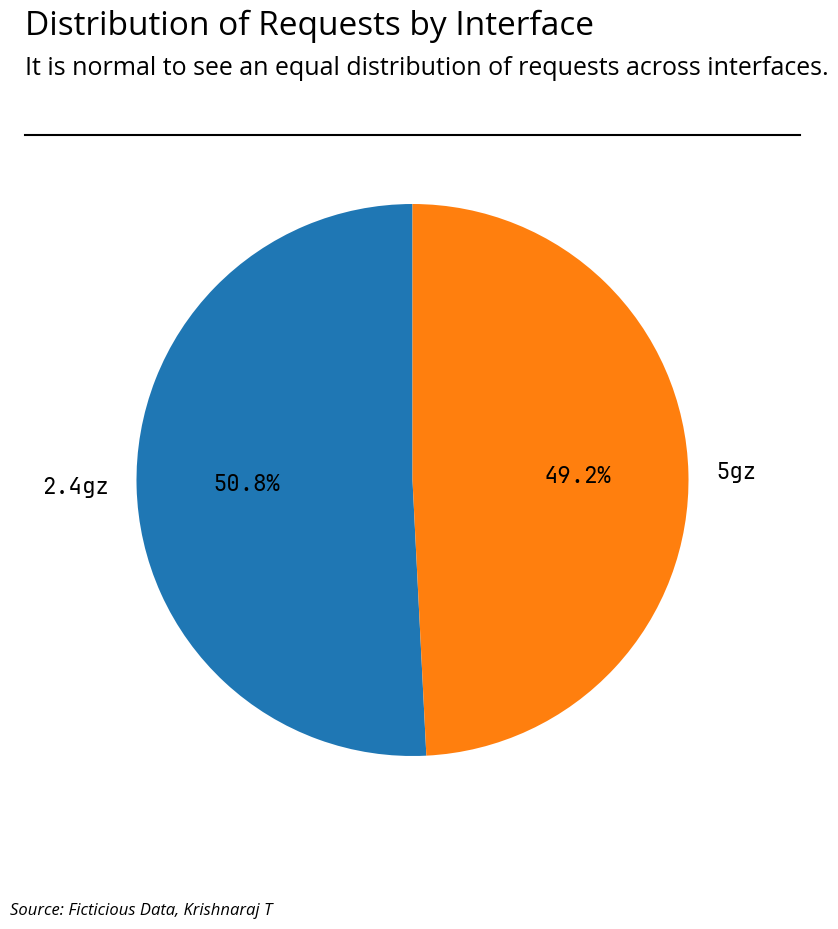

In [9]:
import matplotlib.pyplot as plt

# assuming you have a DataFrame called `normal_log_db` with a column called 'Interface'
interface_counts = normal_log_db['Interface'].value_counts()

# creating the plot. 
fig, ax = plt.subplots(figsize=(10, 10))

# informative title + subtitle
title = 'Distribution of Requests by Interface'
subtitle = 'It is normal to see an equal distribution of requests across interfaces.'

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# set the font size of the labels
plt.rcParams['font.size'] = 16

# Create a pie chart to show the distribution of requests per interface
plt.pie(interface_counts.values, labels=interface_counts.index, autopct='%1.1f%%', startangle=90)


# foot note
footnote = "Source: Ficticious Data, Krishnaraj T"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

# display the plot
plt.show()

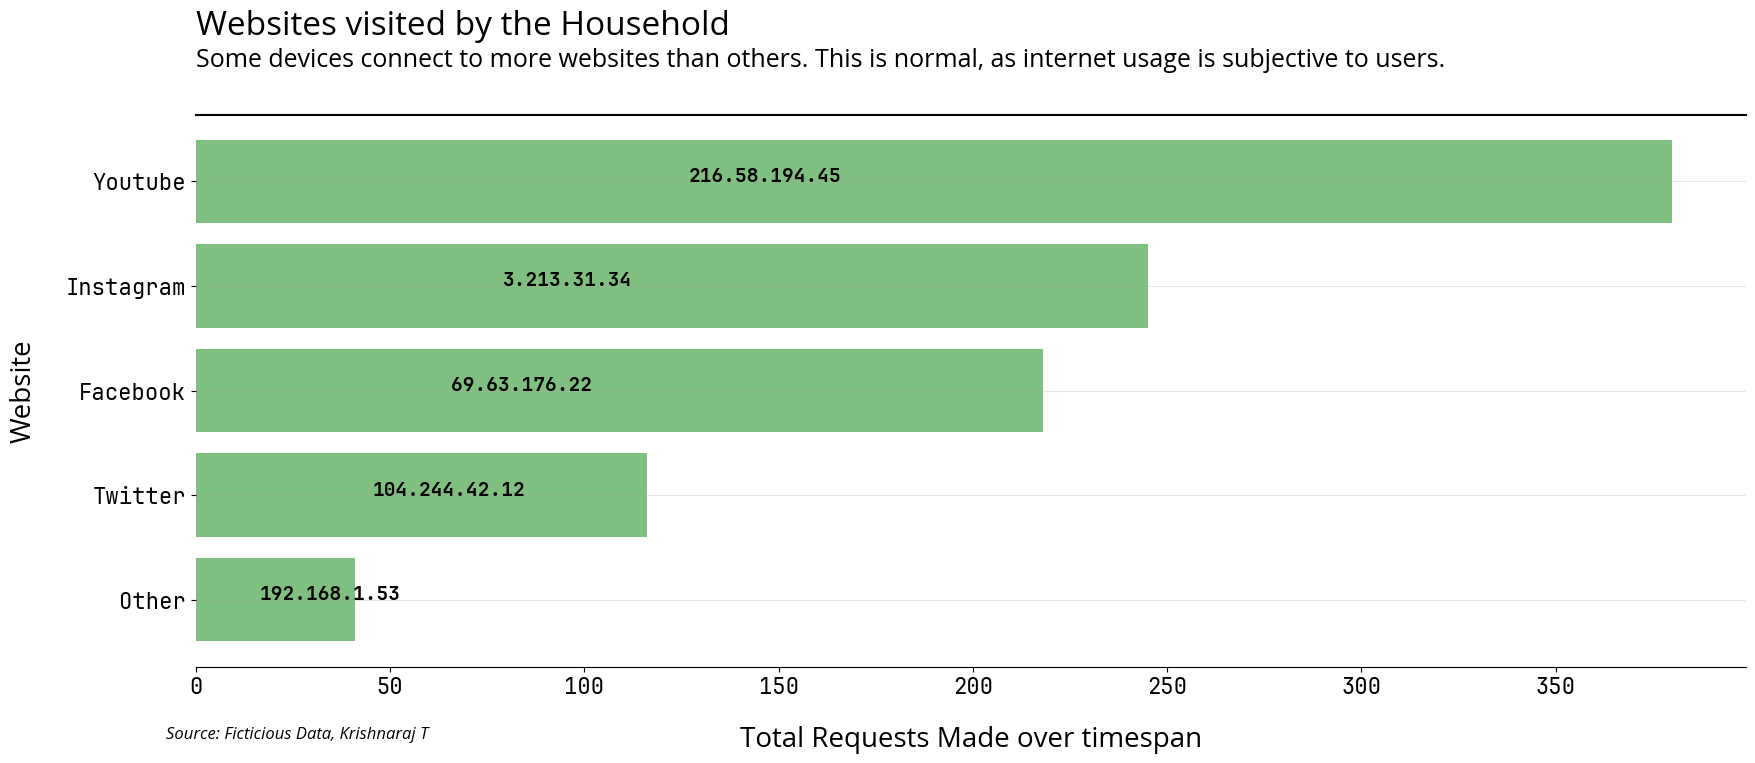

In [10]:
import matplotlib.pyplot as plt

# assuming you have a DataFrame called `normal_log_db` with columns called 'Requested IP' and 'Requested Website'
destination_ips = normal_log_db['Requested IP'].value_counts()
destination_ips = destination_ips.sort_values(ascending=False)

destination_websites = normal_log_db['Requested Website'].value_counts()
destination_websites = destination_websites.sort_values(ascending=False)

destination_ips = destination_ips.iloc[::-1]
destination_websites = destination_websites.iloc[::-1]

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'Websites visited by the Household'
subtitle = 'Some devices connect to more websites than others. This is normal, as internet usage is subjective to users. '

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.3)
# plt.grid(axis='x', alpha=0.2)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)


# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans", labelpad=20)
plt.ylabel('Website', fontsize=20, fontname="Open Sans", labelpad=20)


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# set the y-axis tick labels to the website names
plt.yticks(range(len(destination_websites)), destination_websites.index)

# invert the y-axis so that the website names are displayed from top to bottom
# plt.gca().invert_yaxis()

# add the names of the websites inside their individual bars
for i, v in enumerate(destination_ips.index):
    plt.text(x=destination_ips.values[i] / 3, y=i, s=v, color='black', fontweight='bold', fontsize=14)


# foot note
footnote = "Source: Ficticious Data, Krishnaraj T"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

plt.barh(range(len(destination_websites)), destination_websites.values, color='green', alpha=0.5)


plt.show()

Text(0.11, 0.02, 'Source: Ficticious Data, Krishnaraj T')

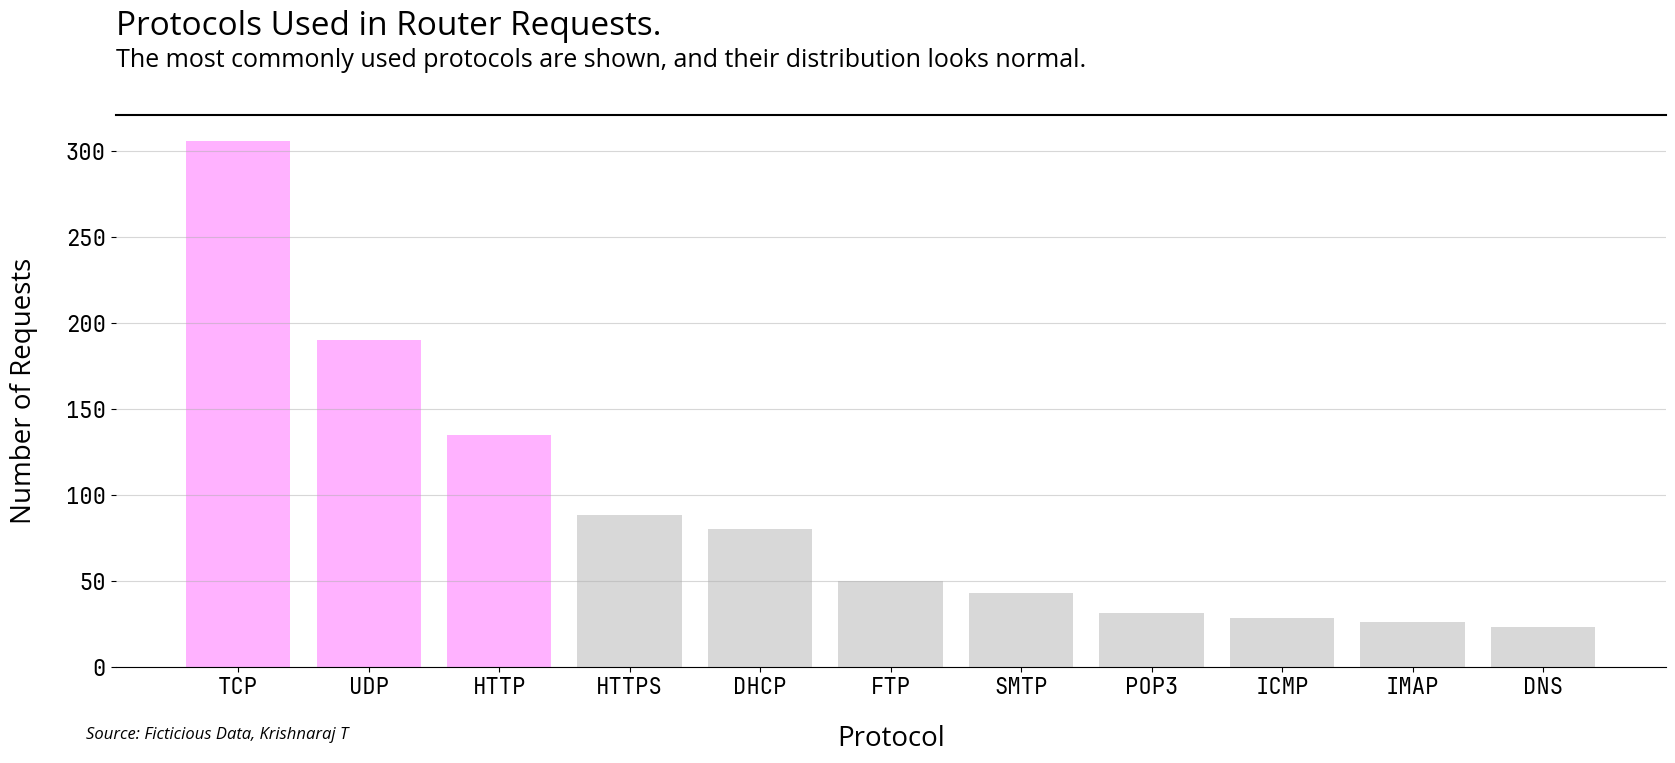

In [11]:
# let us now plot what protocols were used to make requests
# count the number of requests for each protocol

protocol_counts = normal_log_db['Protocol'].value_counts()

# set the color of the first rectangle to pink and the color of the other rectangles to gray
colors = ['magenta'] * 3 + ['gray'] * (len(protocol_counts) - 3)

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'Protocols Used in Router Requests. '
subtitle = 'The most commonly used protocols are shown, and their distribution looks normal.'

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.5)
# plt.grid(axis='x', alpha=0.5)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans", labelpad=20)
plt.ylabel('Website', fontsize=20, fontname="Open Sans", labelpad=20)


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

plt.bar(protocol_counts.index, protocol_counts.values, color=colors, alpha=0.3)

# set the title and axis labels
# ax.set_title('Protocols Used to Make Requests')
ax.set_xlabel('Protocol')
ax.set_ylabel('Number of Requests')

# set the x-axis tick labels to be rotated for better readability
# plt.xticks(rotation=45)


# foot note
footnote = "Source: Ficticious Data, Krishnaraj T"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)


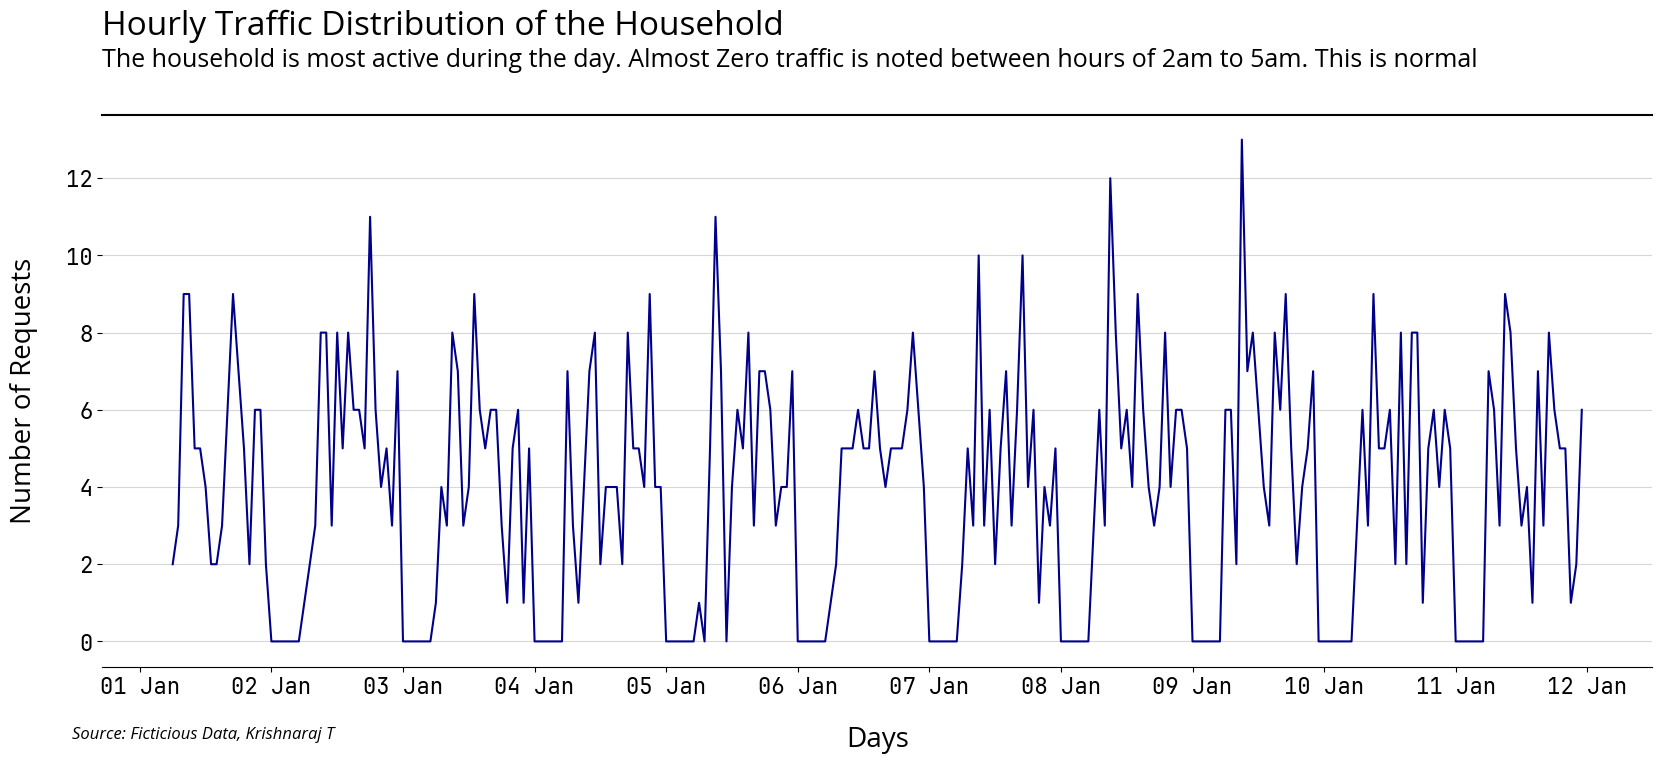

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

temp_df = normal_log_db.copy()
# convert the 'Time' column to a datetime object
temp_df['Time'] = pd.to_datetime(temp_df['Time'])

# set the 'Time' column as the index
temp_df.set_index('Time', inplace=True)

# resample the data by hour and count the number of requests
hourly_counts = temp_df.resample('H').count()['MAC']


# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'Hourly Traffic Distribution of the Household'
subtitle = 'The household is most active during the day. Almost Zero traffic is noted between hours of 2am to 5am. This is normal'

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.5)
# plt.grid(axis='x', alpha=0.5)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans", labelpad=20)
plt.ylabel('Website', fontsize=20, fontname="Open Sans", labelpad=20)


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

ax.set_xlabel('Days')
ax.set_ylabel('Number of Requests')

# set the x-axis tick labels to be rotated for better readability
# plt.xticks(rotation=45)

plt.plot(hourly_counts.index, hourly_counts.values, color='darkblue')

# foot note
footnote = "Source: Ficticious Data, Krishnaraj T"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

# customize the tick labels
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

Text(0.11, 0.02, 'Source: Ficticious Data, Krishnaraj T')

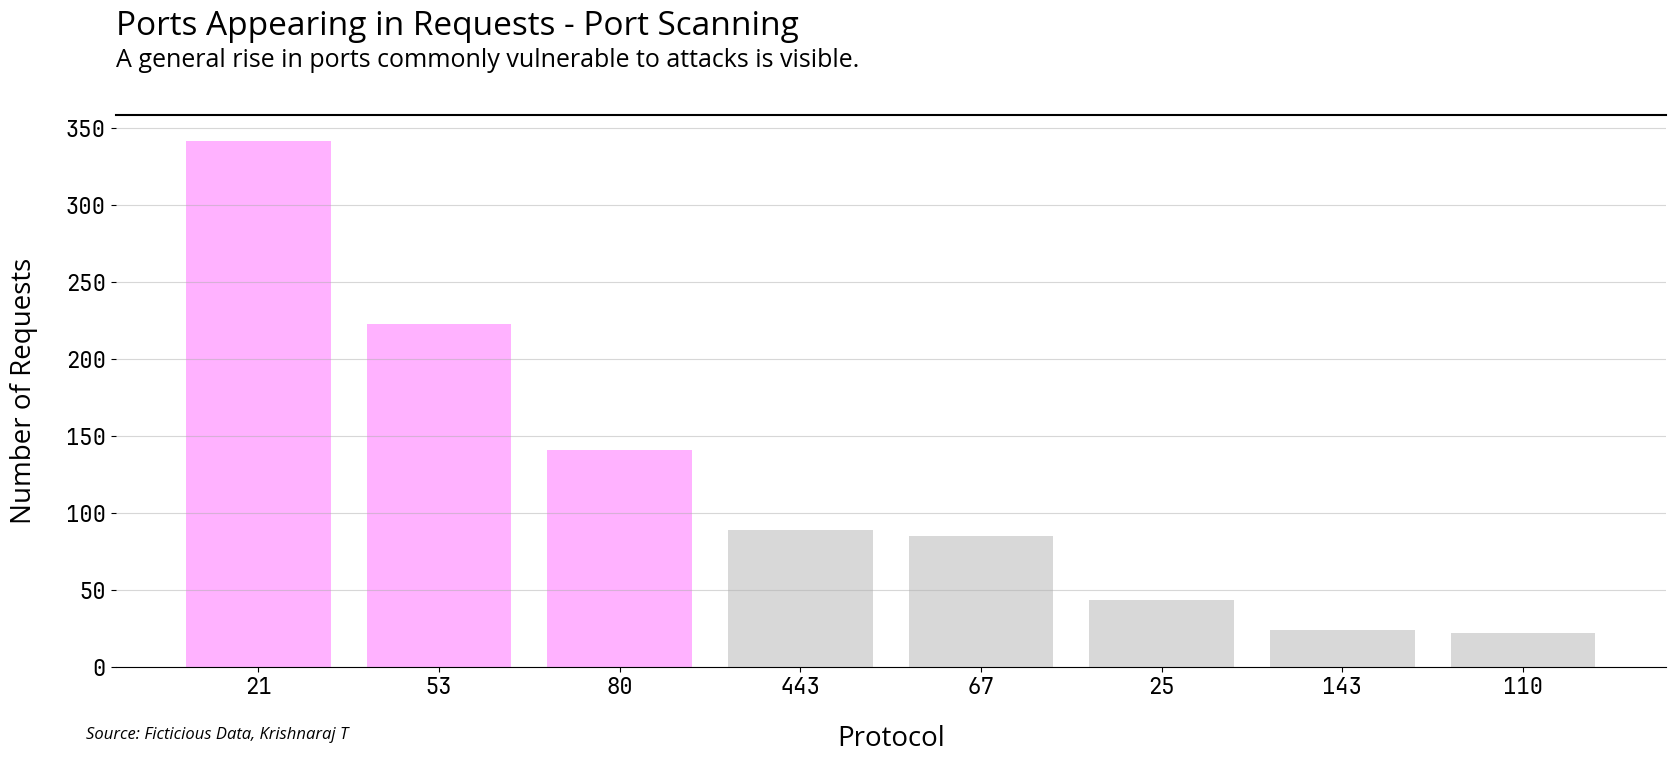

In [13]:
# let us now plot what protocols were used to make requests
# count the number of requests for each protocol

port_counts = normal_log_db['Port'].value_counts()

# change indices from float to int
port_counts.index = port_counts.index.astype(int)
port_counts.index = port_counts.index.astype(str)

port_counts.index

# set the color of the first rectangle to pink and the color of the other rectangles to gray
colors = ['magenta'] * 3 + ['gray'] * (len(port_counts) - 3)

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'Ports Appearing in Requests - Port Scanning'
subtitle = 'A general rise in ports commonly vulnerable to attacks is visible.'

# add title + subtitle to plot
plt.text(
    x=0.125, y=0.90, s=title, fontname="Open Sans",
    fontsize=24, ha='left', transform=fig.transFigure
)
plt.text(
    x=0.125, y=0.86, s=subtitle, fontname="Open Sans",
    fontsize=18, ha='left', transform=fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9],  # x co-ords
    [.80, .80],  # y co-ords
    transform=fig.transFigure,
    clip_on=False,
    color='k',
    linewidth=1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis='y', alpha=0.5)
# plt.grid(axis='x', alpha=0.5)

# turn off spines
plt.gca().spines[['left', 'right', 'top']].set_visible(False)

# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans", labelpad=20)
plt.ylabel('Website', fontsize=20, fontname="Open Sans", labelpad=20)

# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

plt.bar(port_counts.index, port_counts.values, color=colors, alpha=0.3)

# set the title and axis labels
# ax.set_title('Protocols Used to Make Requests')
ax.set_xlabel('Protocol')
ax.set_ylabel('Number of Requests')

# set the x-axis tick labels to be rotated for better readability
# plt.xticks(rotation=45)


# footnote
footnote = "Source: Ficticious Data, Krishnaraj T"
plt.text(
    x=0.11,
    y=0.02,
    s=footnote,
    fontname='Open Sans',
    fontstyle='italic',
    fontsize=12,
    ha='left',
    transform=fig.transFigure
)


# Let us now simulate some attacks

## DDOS Attack

In [14]:
# Writing functions for columns that we wanna generate randomly
def generate_attacker_mac_address():
    return '1c:8c:f5:0d:d2:53'


def generate_dest_ip_address():
    # define the weights for each website
    website_weights = {'Youtube': 15, 'Instagram': 10, 'Facebook': 8, 'Twitter': 5, 'Other': 2}
    
    # create a list of websites based on their weights
    websites = []
    for website, weight in website_weights.items():
        websites.extend([website] * weight)
    
    # randomly select a website from the list
    website = random.choice(websites)
    
    # generate a random IP address for the website
    if website == 'Youtube':
        return ('216.58.194.45' , website)
    elif website == 'Instagram':
        return ('3.213.31.34' , website)
    elif website == 'Facebook':
        return ('69.63.176.22' , website)
    elif website == 'Twitter':
        return ('104.244.42.12' , website)
    else:
        return ('192.168.1.53' , website)

def generate_attacker_ip_address():
    ip = '192.168.1.20'
    return ip

def generate_device_name():
    device_names = ['iPhone', 'Samsung', 'OnePlus', 'Nokia', 'Xiaomi', 'Oppo', 'Vivo', 'Realme', 'Micromax', 'Lenovo']
    return random.choice(device_names)

def generate__attacker_interface(): 
    interfaces = ['5gz', '2.4gz']
    return random.choice(interfaces)

def generate_date_time():
    # generate random date and time, but only in the range of a few days
    start_date = pd.to_datetime('2023-01-01')
    
    # generate random number of days
    days_to_add = random.randint(0, 10)
    
    # generate random number of seconds
    seconds_to_add = random.randint(0, 86400)
    
    # add random days and seconds to start date
    end_date = start_date + pd.Timedelta(days=days_to_add, seconds=seconds_to_add)
    
    # set the hour of the timestamp based on the time of day
    hour = end_date.hour
    if hour < 6:
        # almost no traffic between 2am and 6am
        hour = random.randint(6, 23)
    elif hour < 9:
        # more traffic during the morning hours
        hour = random.randint(6, 10)
    elif hour < 18:
        # most traffic during the daytime
        hour = random.randint(9, 17)
    else:
        # less traffic during the evening hours
        hour = random.randint(17, 23)
    
    # set the hour of the timestamp
    end_date = end_date.replace(hour=hour)
    
    # return timestamp as string
    return end_date.strftime('%Y-%m-%d %H:%M:%S')

def generate_attacker_date_time():
    # generate random date and time, but only on 4th day
    start_date = pd.to_datetime('2023-01-01')
    
    # generate random number of days
    days_to_add = 4
    
    # generate random number of seconds
    seconds_to_add = random.randint(0, 86400)
    
    # add random days and seconds to start date
    end_date = start_date + pd.Timedelta(days=days_to_add, seconds=seconds_to_add)
    
    # set the hour of the timestamp based on the time of day
    hour = 19
    
    # set the hour of the timestamp
    end_date = end_date.replace(hour=hour)
    
    # return timestamp as string
    return end_date.strftime('%Y-%m-%d %H:%M:%S')

def gen_attacker_protocols():
    protocols = ['TCP', 'UDP', 'DHCP', 'HTTP', 'HTTPS', 'FTP', 'SMTP', 'POP3', 'IMAP', 'DNS', 'ICMP']
    ports = {
        'TCP': 21,          # HTTP
        'UDP': 53,          # DNS
        'DHCP': 67,         # DHCP Server
        'HTTP': 80,         # Hypertext Transfer Protocol
        'HTTPS': 443,       # HTTP Secure (TLS/SSL)
        'FTP': 21,          # File Transfer Protocol (Control)
        'SMTP': 25,         # Simple Mail Transfer Protocol
        'POP3': 110,        # Post Office Protocol v3
        'IMAP': 143,        # Internet Message Access Protocol
        'DNS': 53,          # Domain Name System
        'ICMP': None        # Internet Control Message Protocol (does not use ports)
    }
    weights = [0.2, 0.2, 0.3, 0.15, 0.0, 0.05, 0.05, 0.025, 0.025, 0.025, 0.35]
    selection = random.choices(protocols, weights=weights)[0]
    return (selection, ports[selection])

In [15]:
# Generate ddos attack data, consider a home environment. with 10 users. across a span of 10 days. Visiting 100 websites per device per day. 

ddos_log_db = pd.DataFrame(columns=['MAC', 'IP Address', 'Device Name', 'Interface', 'Requested IP', 'Time'])

for i in range(10):
    
    
    # check if time columns is on 4th jan
    if i == 4:
        temp_df = pd.DataFrame({
            'MAC' : [generate_mac_address() for j in range(100)],
            'IP Address': [generate_attacker_ip_address() for j in range(100)],
            'Device Name': [generate_device_name() if j > 50 else 'Vivo' for j in range(100)],
            'Interface': [generate_interface() for j in range(100)],
            'Requested IP': [generate_dest_ip_address()[0] for j in range(100)],
            'Requested Website': [generate_dest_ip_address()[1] for j in range(100)],
            'Protocol': [gen_attacker_protocols()[0] for j in range(100)],
            'Port': [gen_attacker_protocols()[1] for j in range(100)],
            'Time': [generate_attacker_date_time() if j < 50 else generate_date_time() for j in range(100)]
        })
    
    else:
        temp_df = pd.DataFrame({
            'MAC' : [generate_mac_address() for j in range(100)],
            'IP Address': [generate_device_ip_address() for j in range(100)],
            'Device Name': [generate_device_name() for j in range(100)],
            'Interface': [generate_interface() for j in range(100)],
            'Requested IP': [generate_dest_ip_address()[0] for j in range(100)],
            'Requested Website': [generate_dest_ip_address()[1] for j in range(100)],
            'Protocol': [gen_protocols()[0] for j in range(100)],
            'Port': [gen_protocols()[1]  for j in range(100)],
            'Time': [generate_date_time() for j in range(100)]
    })
    
    ddos_log_db = pd.concat([ddos_log_db, temp_df], ignore_index=True)

ddos_log_db

,MAC,IP Address,Device Name,Interface,Requested IP,Time,Requested Website,Protocol,Port
0,ac:89:3d:ce:66:83,192.168.1.20,Lenovo,2.4gz,216.58.194.45,2023-01-10 11:51:02,Instagram,HTTP,53.0
1,0d:da:8e:61:96:71,192.168.1.10,iPhone,2.4gz,69.63.176.22,2023-01-04 06:48:03,Facebook,FTP,53.0
2,cb:bc:fe:b7:b8:b5,192.168.1.90,Realme,5gz,69.63.176.22,2023-01-06 06:33:14,Facebook,UDP,67.0
3,4b:5d:a0:17:a6:b0,192.168.1.40,Oppo,2.4gz,216.58.194.45,2023-01-06 17:52:46,Other,TCP,NaN
4,bf:37:eb:cf:7a:5d,192.168.1.40,iPhone,2.4gz,69.63.176.22,2023-01-08 14:29:35,Youtube,UDP,21.0
...,...,...,...,...,...,...,...,...,...
995,5a:27:4f:5a:e3:44,192.168.1.60,Samsung,2.4gz,216.58.194.45,2023-01-11 17:47:55,Twitter,HTTPS,25.0
996,41:b7:80:10:39:f3,192.168.1.70,Vivo,5gz,216.58.194.45,2023-01-03 21:55:14,Instagram,TCP,53.0
997,e0:10:27:af:54:56,192.168.1.50,Micromax,2.4gz,216.58.194.45,2023-01-03 09:33:54,Youtube,UDP,80.0
998,1f:73:de:ae:87:cc,192.168.1.40,Nokia,5gz,69.63.176.22,2023-01-08 15:51:07,Youtube,TCP,53.0


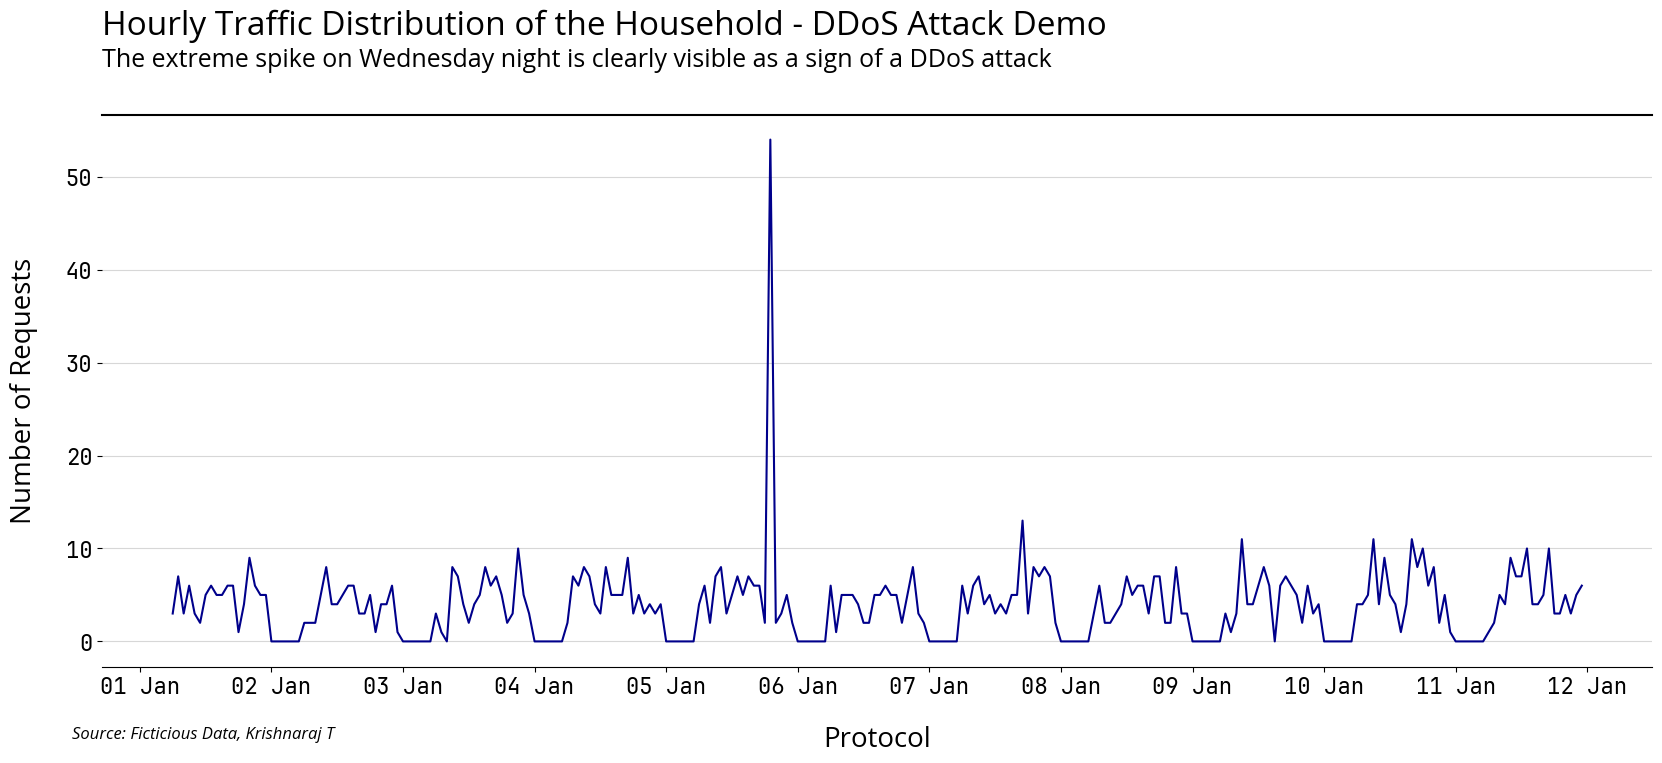

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

temp_df = ddos_log_db.copy()
# convert the 'Time' column to a datetime object
temp_df['Time'] = pd.to_datetime(temp_df['Time'])

# set the 'Time' column as the index
temp_df.set_index('Time', inplace=True)

# resample the data by hour and count the number of requests
hourly_counts = temp_df.resample('H').count()['MAC']


# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'Hourly Traffic Distribution of the Household - DDoS Attack Demo'
subtitle = 'The extreme spike on Wednesday night is clearly visible as a sign of a DDoS attack'

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.5)
# plt.grid(axis='x', alpha=0.5)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans", labelpad=20)
plt.ylabel('Website', fontsize=20, fontname="Open Sans", labelpad=20)


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# ax.set_title('Protocols Used to Make Requests')
ax.set_xlabel('Protocol')
ax.set_ylabel('Number of Requests')

# set the x-axis tick labels to be rotated for better readability
# plt.xticks(rotation=45)

plt.plot(hourly_counts.index, hourly_counts.values, color='darkblue')

# foot note
footnote = "Source: Ficticious Data, Krishnaraj T"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

# customize the tick labels
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))



Text(0.11, 0.02, 'Source: Ficticious Data, Krishnaraj T')

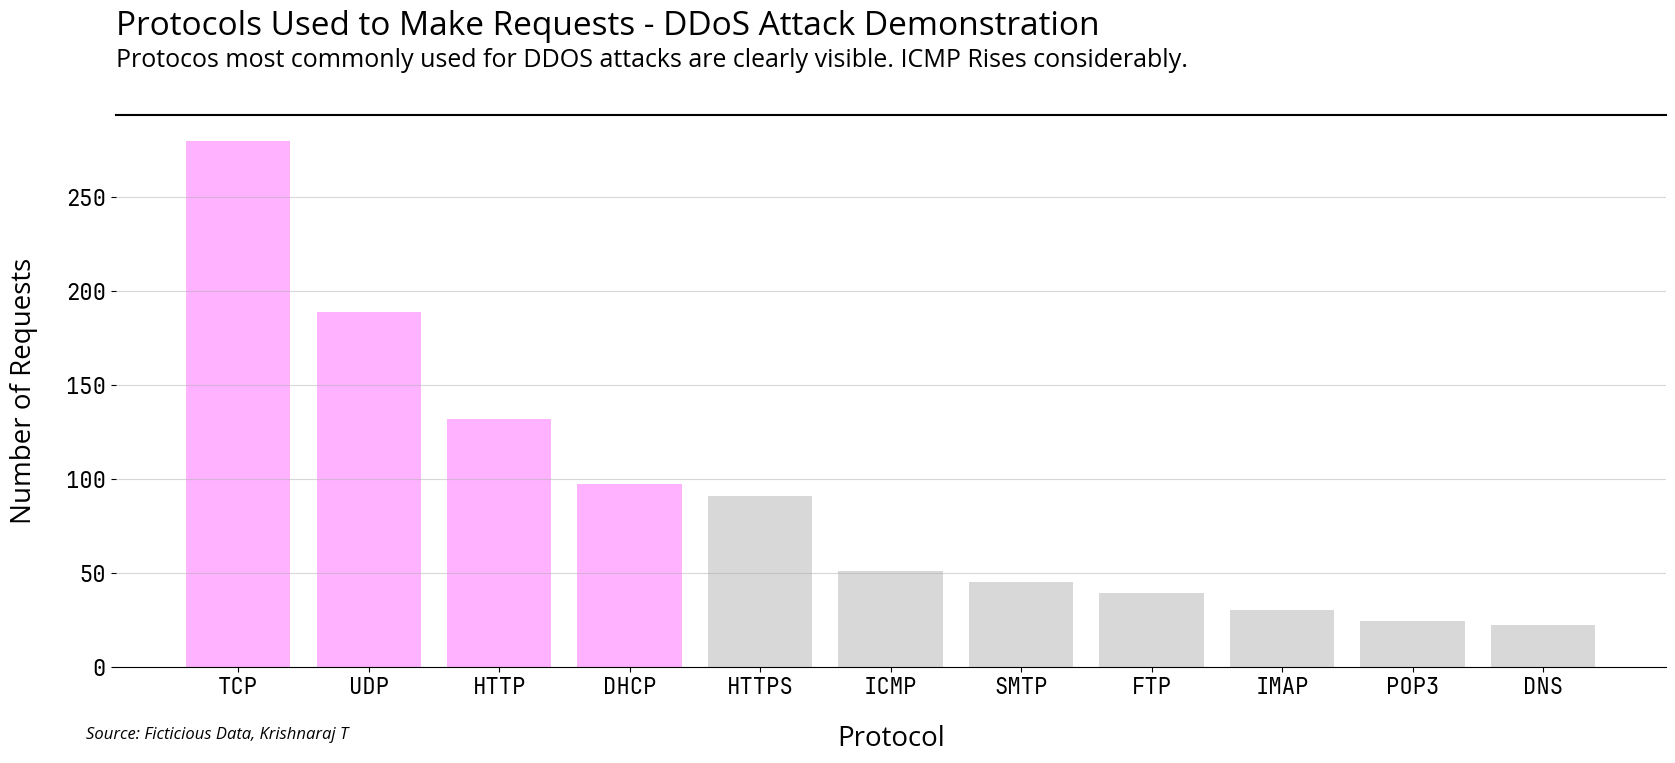

In [17]:
# let us now plot what protocols were used to make requests
# count the number of requests for each protocol

protocol_counts = ddos_log_db['Protocol'].value_counts()

# set the color of the first rectangle to pink and the color of the other rectangles to gray
colors = ['magenta'] * 4 + ['gray'] * (len(protocol_counts) - 4)

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'Protocols Used to Make Requests - DDoS Attack Demonstration'
subtitle = 'Protocos most commonly used for DDOS attacks are clearly visible. ICMP Rises considerably. ' 

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.5)
# plt.grid(axis='x', alpha=0.5)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans", labelpad=20)
plt.ylabel('Website', fontsize=20, fontname="Open Sans", labelpad=20)


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

plt.bar(protocol_counts.index, protocol_counts.values, color=colors, alpha=0.3)

# set the title and axis labels
# ax.set_title('Protocols Used to Make Requests')
ax.set_xlabel('Protocol')
ax.set_ylabel('Number of Requests')

# set the x-axis tick labels to be rotated for better readability
# plt.xticks(rotation=45)


# foot note
footnote = "Source: Ficticious Data, Krishnaraj T"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)


/tmp/ipykernel_1371293/392571808.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(dates.index, dates.values, color='purple', marker='o', linestyle='dashed', linewidth=1, markersize=5)


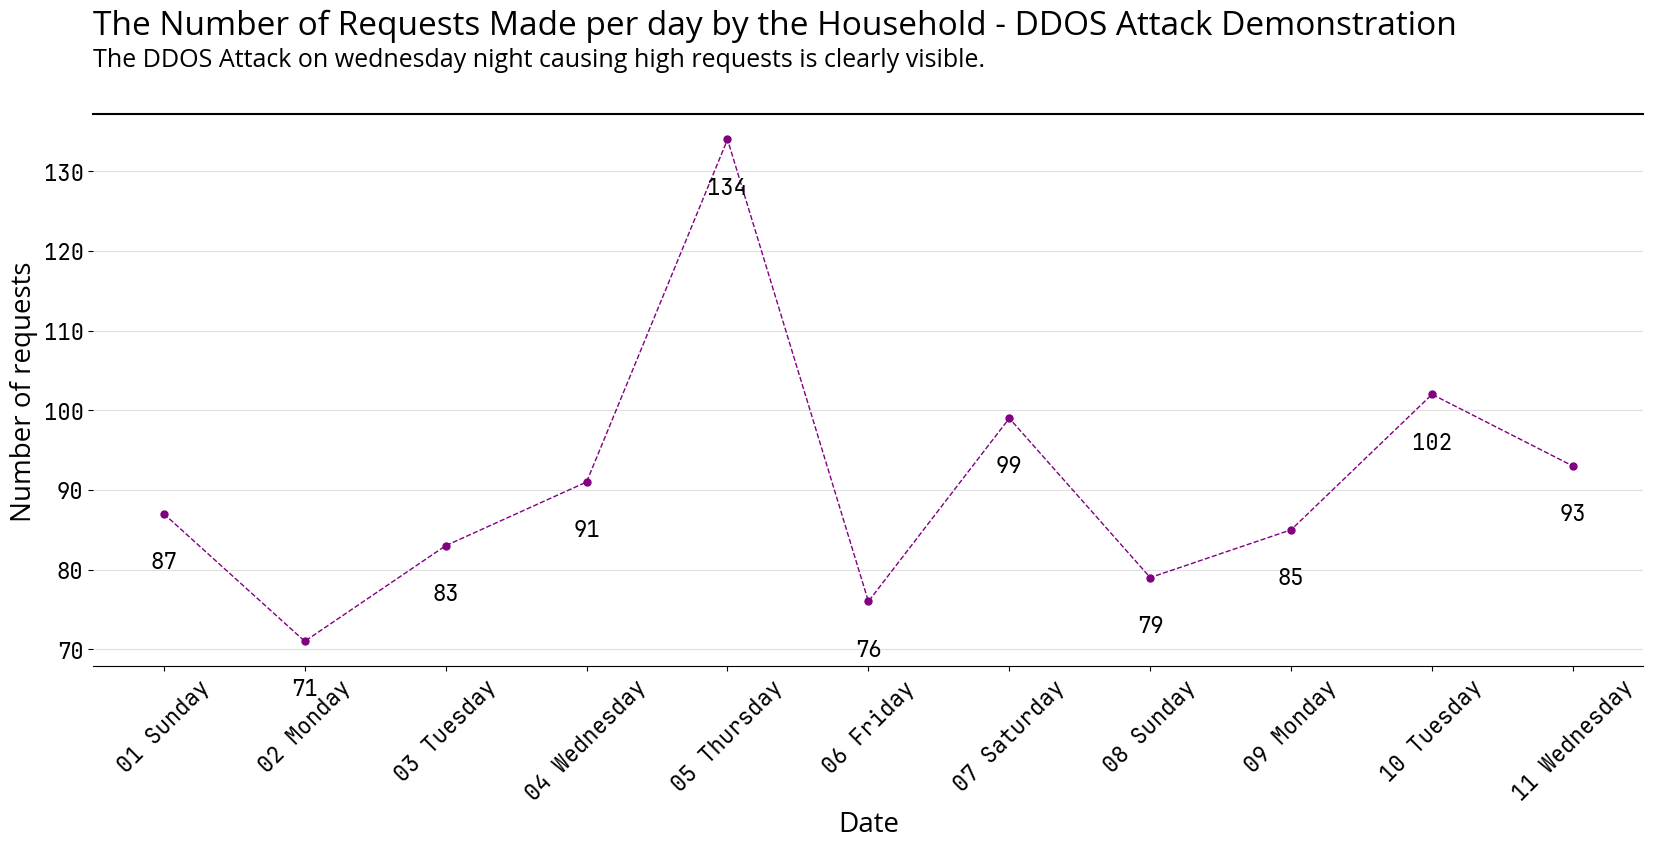

In [18]:
# let us plot the number of requests per day
ddos_log_db['Time'] = pd.to_datetime(ddos_log_db['Time'])
ddos_log_db['Date'] = ddos_log_db['Time'].dt.date 

# sort data by date
ddos_log_db = ddos_log_db.sort_values(by=['Date'])

ddos_log_db.head()

# now let us plot the number of requests per day
dates = ddos_log_db['Date'].value_counts()

# sorting dates
dates = dates.sort_index()

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'The Number of Requests Made per day by the Household - DDOS Attack Demonstration'
subtitle = 'The DDOS Attack on wednesday night causing high requests is clearly visible. '

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)

plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# plotting as a time series
plt.plot_date(dates.index, dates.values, color='purple', marker='o', linestyle='dashed', linewidth=1, markersize=5)

# also put labels on the markers a little over the markers for visibility
for i in range(len(dates)):
    plt.text(dates.index[i], dates.values[i]-6, dates.values[i], ha='center', va='center', color='black', fontsize=16)
    
# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Date', fontsize=20, fontname="Open Sans")
plt.ylabel('Number of requests', fontsize=20, fontname="Open Sans")

# change space on top of chart we are actually adjusting the scale of the plot as well. 
plt.subplots_adjust(top=0.8, wspace=0.3)

# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# tilt the x-axis labels by 45 degrees
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.4)
# plt.grid(axis='x', alpha=0.2)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# customize the tick labels
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %A'))

plt.show()

In [19]:
# let us now plot the number of requests per device

devices = ddos_log_db['IP Address'].value_counts()
devices

IP Address
192.168.1.20     187
192.168.1.40     105
192.168.1.10     101
192.168.1.50      98
192.168.1.90      90
192.168.1.80      89
192.168.1.60      84
192.168.1.30      83
192.168.1.100     82
192.168.1.70      81
Name: count, dtype: int64

<BarContainer object of 10 artists>

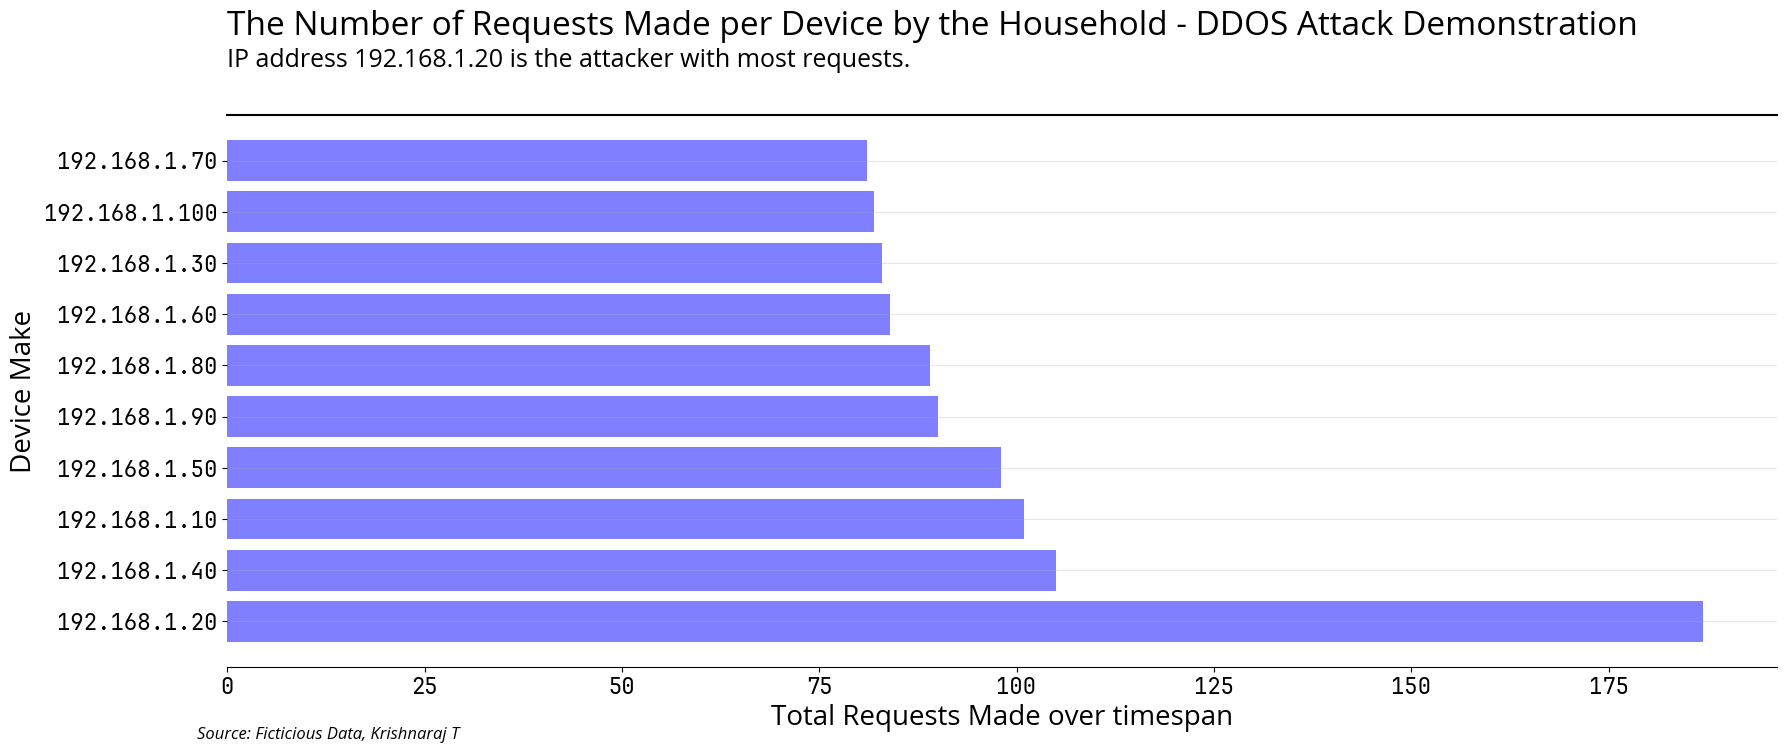

In [20]:

# sorting devices in descending order
devices = devices.sort_values(ascending=False)

# plotting

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'The Number of Requests Made per Device by the Household - DDOS Attack Demonstration'
subtitle = 'IP address 192.168.1.20 is the attacker with most requests. '

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.3)
# plt.grid(axis='x', alpha=0.2)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)


# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans")
plt.ylabel('Device Make', fontsize=20, fontname="Open Sans")


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# foot note
footnote = "Source: Ficticious Data, Krishnaraj T"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

plt.barh(devices.index, devices.values, color='blue', alpha=0.5)


## Instagram Account Compromised

In [21]:
# Writing functions for columns that we wanna generate randomly
def generate_attacker_mac_address():
    return '1c:8c:f5:0d:d2:53'

def generate_attacker_dest_ip_address():
    # define the weights for each website
    website_weights = {'Youtube': 15, 'Instagram': 100, 'Facebook': 8, 'Twitter': 5, 'Other': 2}
    
    # create a list of websites based on their weights
    websites = []
    for website, weight in website_weights.items():
        websites.extend([website] * weight)
    
    # randomly select a website from the list
    website = random.choice(websites)
    
    # generate a random IP address for the website
    if website == 'Youtube':
        return ('216.58.194.45' , website)
    elif website == 'Instagram':
        return ('3.213.31.34' , website)
    elif website == 'Facebook':
        return ('69.63.176.22' , website)
    elif website == 'Twitter':
        return ('104.244.42.12' , website)
    else:
        return ('192.168.1.53' , website)


def generate_dest_ip_address():
    # define the weights for each website
    website_weights = {'Youtube': 8, 'Instagram': 10, 'Facebook': 8, 'Twitter': 5, 'Other': 2}
    
    # create a list of websites based on their weights
    websites = []
    for website, weight in website_weights.items():
        websites.extend([website] * weight)
    
    # randomly select a website from the list
    website = random.choice(websites)
    
    # generate a random IP address for the website
    if website == 'Youtube':
        return ('216.58.194.45' , website)
    elif website == 'Instagram':
        return ('3.213.31.34' , website)
    elif website == 'Facebook':
        return ('69.63.176.22' , website)
    elif website == 'Twitter':
        return ('104.244.42.12' , website)
    else:
        return ('192.168.1.53' , website)

def generate_attacker_ip_address():
    ip = '192.168.1.20'
    return ip

def generate_device_name():
    device_names = ['iPhone', 'Samsung', 'OnePlus', 'Nokia', 'Xiaomi', 'Oppo', 'Vivo', 'Realme', 'Micromax', 'Lenovo']
    return random.choice(device_names)

def generate__attacker_interface(): 
    interfaces = ['5gz', '2.4gz']
    return random.choice(interfaces)

def generate_date_time():
    # generate random date and time, but only in the range of a few days
    start_date = pd.to_datetime('2023-01-01')
    
    # generate random number of days
    days_to_add = random.randint(0, 10)
    
    # generate random number of seconds
    seconds_to_add = random.randint(0, 86400)
    
    # add random days and seconds to start date
    end_date = start_date + pd.Timedelta(days=days_to_add, seconds=seconds_to_add)
    
    # set the hour of the timestamp based on the time of day
    hour = end_date.hour
    if hour < 6:
        # almost no traffic between 2am and 6am
        hour = random.randint(6, 23)
    elif hour < 9:
        # more traffic during the morning hours
        hour = random.randint(6, 10)
    elif hour < 18:
        # most traffic during the daytime
        hour = random.randint(9, 17)
    else:
        # less traffic during the evening hours
        hour = random.randint(17, 23)
    
    # set the hour of the timestamp
    end_date = end_date.replace(hour=hour)
    
    # return timestamp as string
    return end_date.strftime('%Y-%m-%d %H:%M:%S')

def generate_attacker_date_time():
    # generate random date and time, but only on 4th day
    start_date = pd.to_datetime('2023-01-01')
    
    # generate random number of days
    days_to_add = 7
    
    # generate random number of seconds
    seconds_to_add = random.randint(0, 86400)
    
    # add random days and seconds to start date
    end_date = start_date + pd.Timedelta(days=days_to_add, seconds=seconds_to_add)
    
    # set the hour of the timestamp based on the time of day
    hour = 19
    
    # set the hour of the timestamp
    end_date = end_date.replace(hour=hour)
    
    # return timestamp as string
    return end_date.strftime('%Y-%m-%d %H:%M:%S')

def gen_attacker_protocols():
    protocols = ['TCP', 'UDP', 'DHCP', 'HTTP', 'HTTPS', 'FTP', 'SMTP', 'POP3', 'IMAP', 'DNS', 'ICMP']
    weights = [0.4, 0.5, 0.3, 0.15, 0.1, 0.05, 0.05, 0.025, 0.025, 0.025, 0.35]
    return random.choices(protocols, weights=weights)[0]

In [22]:
# Generate insta brute force attack data, consider a home environment. with 10 users. across a span of 10 days. Visiting 100 websites per device per day. 

insta_brute_force_db = pd.DataFrame(columns=['MAC', 'IP Address', 'Device Name', 'Interface', 'Requested IP', 'Time'])

for i in range(10):
    # check if time columns is on 4th jan
    if i == 7:
        temp_df = pd.DataFrame({
            'MAC' : [generate_attacker_mac_address() for j in range(100)],
            'IP Address': [generate_attacker_ip_address() for j in range(100)],
            'Device Name': [generate_device_name() if j > 50 else 'Vivo' for j in range(100)],
            'Interface': [generate_interface() for j in range(100)],
            'Requested IP': [generate_dest_ip_address()[0] for j in range(100)],
            'Requested Website': [generate_attacker_dest_ip_address()[1] for j in range(100)],
            'Protocol': [gen_attacker_protocols() if j < 50 else gen_protocols() for j in range(100)],
            'Time': [generate_attacker_date_time() if j < 50 else generate_date_time() for j in range(100)]
        })
    
    else:
        temp_df = pd.DataFrame({
            'MAC' : [generate_mac_address() for j in range(100)],
            'IP Address': [generate_device_ip_address() for j in range(100)],
            'Device Name': [generate_device_name() for j in range(100)],
            'Interface': [generate_interface() for j in range(100)],
            'Requested IP': [generate_dest_ip_address()[0] for j in range(100)],
            'Requested Website': [generate_dest_ip_address()[1] for j in range(100)],
            'Protocol': [gen_attacker_protocols() for j in range(100)],
            'Time': [generate_date_time() for j in range(100)]
    })
    
    insta_brute_force_db = pd.concat([insta_brute_force_db, temp_df], ignore_index=True)

insta_brute_force_db

,MAC,IP Address,Device Name,Interface,Requested IP,Time,Requested Website,Protocol
0,2c:a2:6d:d7:4d:95,192.168.1.30,Xiaomi,2.4gz,69.63.176.22,2023-01-07 13:15:56,Youtube,SMTP
1,4d:28:71:f8:33:42,192.168.1.40,OnePlus,2.4gz,216.58.194.45,2023-01-10 15:25:23,Instagram,DHCP
2,50:47:ca:97:8b:ef,192.168.1.80,OnePlus,5gz,69.63.176.22,2023-01-03 15:44:14,Twitter,TCP
3,e4:fb:ab:37:11:e3,192.168.1.40,Oppo,2.4gz,69.63.176.22,2023-01-06 20:00:19,Youtube,HTTPS
4,94:e8:1a:89:bf:a1,192.168.1.20,iPhone,5gz,216.58.194.45,2023-01-11 12:35:29,Youtube,UDP
...,...,...,...,...,...,...,...,...
995,7b:ee:0a:0f:fa:46,192.168.1.20,Xiaomi,5gz,69.63.176.22,2023-01-08 17:14:18,Instagram,TCP
996,b3:70:45:97:7f:8f,192.168.1.90,Xiaomi,2.4gz,69.63.176.22,2023-01-09 10:54:10,Facebook,TCP
997,01:ab:22:5a:15:8f,192.168.1.60,Nokia,2.4gz,3.213.31.34,2023-01-01 17:40:04,Facebook,HTTPS
998,35:82:e7:e0:2b:ef,192.168.1.10,Nokia,2.4gz,192.168.1.53,2023-01-08 20:08:56,Youtube,TCP


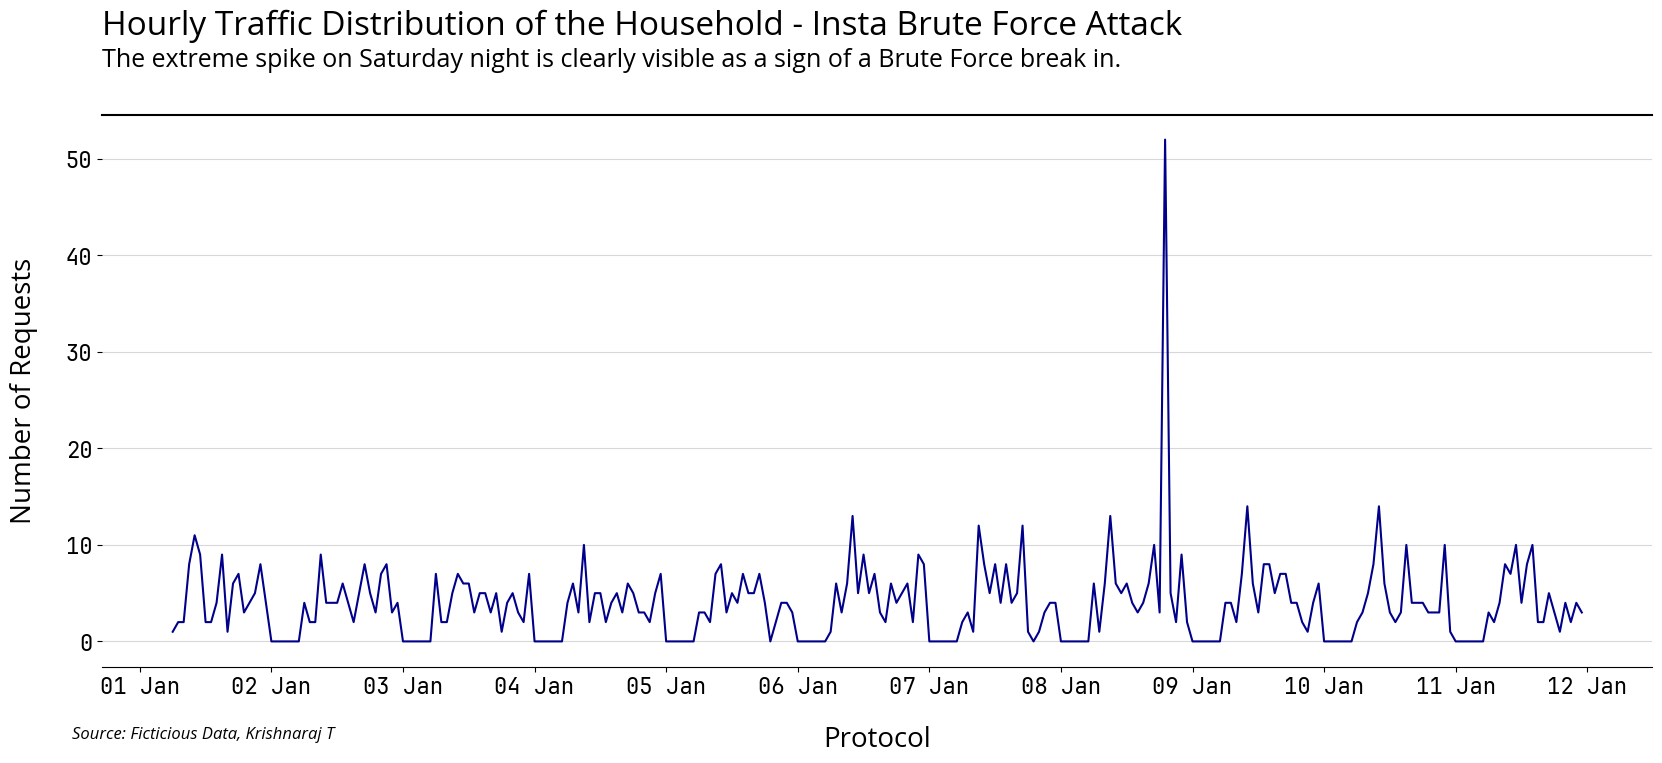

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

temp_df = insta_brute_force_db.copy()
# convert the 'Time' column to a datetime object
temp_df['Time'] = pd.to_datetime(temp_df['Time'])

# set the 'Time' column as the index
temp_df.set_index('Time', inplace=True)

# resample the data by hour and count the number of requests
hourly_counts = temp_df.resample('H').count()['MAC']


# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'Hourly Traffic Distribution of the Household - Insta Brute Force Attack'
subtitle = 'The extreme spike on Saturday night is clearly visible as a sign of a Brute Force break in. '

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.5)
# plt.grid(axis='x', alpha=0.5)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans", labelpad=20)
plt.ylabel('Website', fontsize=20, fontname="Open Sans", labelpad=20)


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# ax.set_title('Protocols Used to Make Requests')
ax.set_xlabel('Protocol')
ax.set_ylabel('Number of Requests')

# set the x-axis tick labels to be rotated for better readability
# plt.xticks(rotation=45)

plt.plot(hourly_counts.index, hourly_counts.values, color='darkblue')

# foot note
footnote = "Source: Ficticious Data, Krishnaraj T"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

# customize the tick labels
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))



/tmp/ipykernel_1371293/3146978229.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(dates.index, dates.values, color='purple', marker='o', linestyle='dashed', linewidth=1, markersize=5)


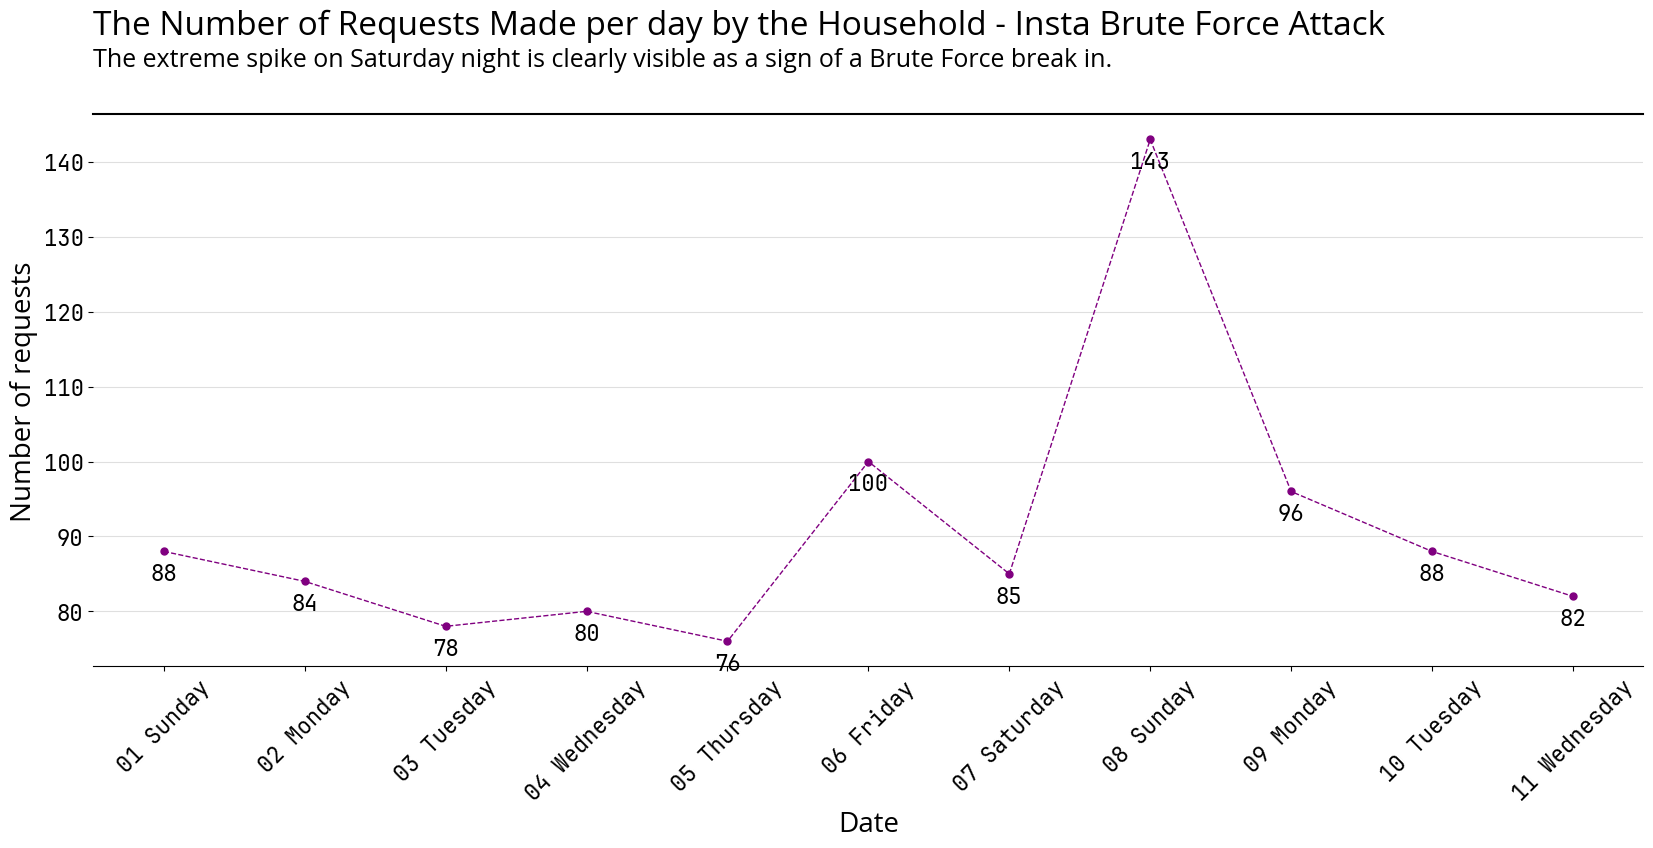

In [24]:
# let us plot the number of requests per day
insta_brute_force_db['Time'] = pd.to_datetime(insta_brute_force_db['Time'])
insta_brute_force_db['Date'] = insta_brute_force_db['Time'].dt.date 

# sort data by date
insta_brute_force_db = insta_brute_force_db.sort_values(by=['Date'])

insta_brute_force_db.head()

# now let us plot the number of requests per day
dates = insta_brute_force_db['Date'].value_counts()

# sorting dates
dates = dates.sort_index()

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'The Number of Requests Made per day by the Household - Insta Brute Force Attack'
subtitle = 'The extreme spike on Saturday night is clearly visible as a sign of a Brute Force break in.'

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)

plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# plotting as a time series
plt.plot_date(dates.index, dates.values, color='purple', marker='o', linestyle='dashed', linewidth=1, markersize=5)

# also put labels on the markers a little over the markers for visibility
for i in range(len(dates)):
    plt.text(dates.index[i], dates.values[i]-3, dates.values[i], ha='center', va='center', color='black', fontsize=16)
    
# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Date', fontsize=20, fontname="Open Sans")
plt.ylabel('Number of requests', fontsize=20, fontname="Open Sans")

# change space on top of chart we are actually adjusting the scale of the plot as well. 
plt.subplots_adjust(top=0.8, wspace=0.3)

# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# tilt the x-axis labels by 45 degrees
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.4)
# plt.grid(axis='x', alpha=0.2)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# customize the tick labels
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %A'))

plt.show()

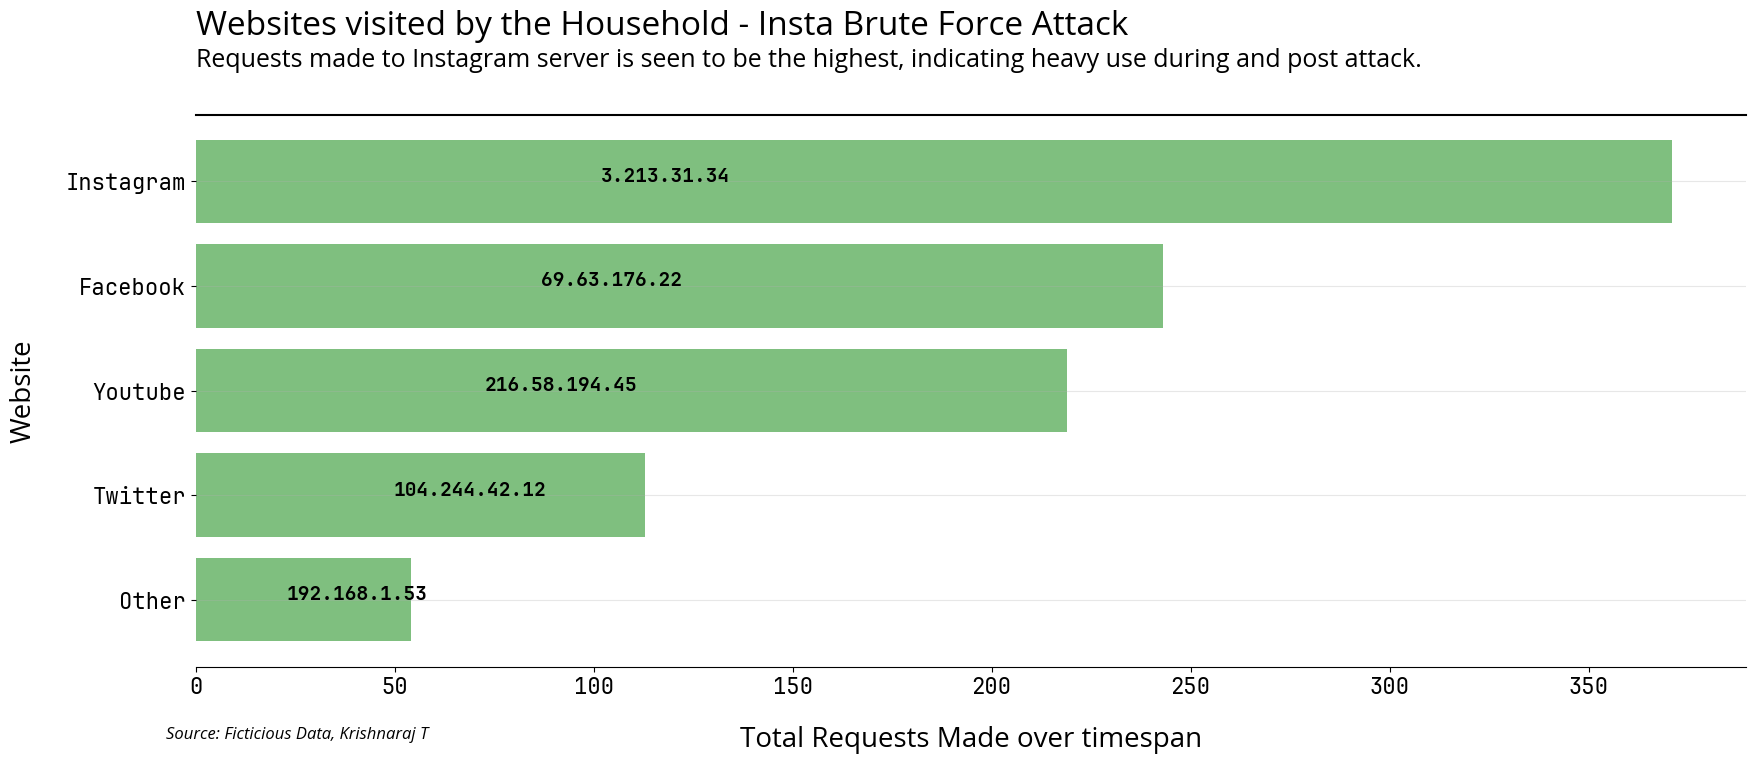

In [25]:
import matplotlib.pyplot as plt

# assuming you have a DataFrame called `normal_log_db` with columns called 'Requested IP' and 'Requested Website'
destination_ips = insta_brute_force_db['Requested IP'].value_counts()
destination_ips = destination_ips.sort_values(ascending=False)

destination_websites = insta_brute_force_db['Requested Website'].value_counts()
destination_websites = destination_websites.sort_values(ascending=False)

destination_ips = destination_ips.iloc[::-1]
destination_websites = destination_websites.iloc[::-1]

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'Websites visited by the Household - Insta Brute Force Attack'
subtitle = 'Requests made to Instagram server is seen to be the highest, indicating heavy use during and post attack. '

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.3)
# plt.grid(axis='x', alpha=0.2)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)


# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans", labelpad=20)
plt.ylabel('Website', fontsize=20, fontname="Open Sans", labelpad=20)


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# set the y-axis tick labels to the website names
plt.yticks(range(len(destination_websites)), destination_websites.index)

# invert the y-axis so that the website names are displayed from top to bottom
# plt.gca().invert_yaxis()

# add the names of the websites inside their individual bars
for i, v in enumerate(destination_ips.index):
    plt.text(x=destination_ips.values[i] / 3, y=i, s=v, color='black', fontweight='bold', fontsize=14)


# foot note
footnote = "Source: Ficticious Data, Krishnaraj T"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

plt.barh(range(len(destination_websites)), destination_websites.values, color='green', alpha=0.5)


plt.show()

## Port Scanning
This is a surveillance technique that is used to identify open ports on a system. This is used by hackers to identify vulnerable ports on a system.

In [26]:
# Writing functions for columns that we wanna generate randomly
def generate_attacker_mac_address():
    return '1c:8c:f5:0d:d2:53'

def generate_attacker_dest_ip_address():
    # define the weights for each website
    website_weights = {'Youtube': 15, 'Instagram': 100, 'Facebook': 8, 'Twitter': 5, 'Other': 2}
    
    # create a list of websites based on their weights
    websites = []
    for website, weight in website_weights.items():
        websites.extend([website] * weight)
    
    # randomly select a website from the list
    website = random.choice(websites)
    
    # generate a random IP address for the website
    if website == 'Youtube':
        return ('216.58.194.45' , website)
    elif website == 'Instagram':
        return ('3.213.31.34' , website)
    elif website == 'Facebook':
        return ('69.63.176.22' , website)
    elif website == 'Twitter':
        return ('104.244.42.12' , website)
    else:
        return ('192.168.1.53' , website)


def generate_dest_ip_address():
    # define the weights for each website
    website_weights = {'Youtube': 8, 'Instagram': 10, 'Facebook': 8, 'Twitter': 5, 'Other': 2}
    
    # create a list of websites based on their weights
    websites = []
    for website, weight in website_weights.items():
        websites.extend([website] * weight)
    
    # randomly select a website from the list
    website = random.choice(websites)
    
    # generate a random IP address for the website
    if website == 'Youtube':
        return ('216.58.194.45' , website)
    elif website == 'Instagram':
        return ('3.213.31.34' , website)
    elif website == 'Facebook':
        return ('69.63.176.22' , website)
    elif website == 'Twitter':
        return ('104.244.42.12' , website)
    else:
        return ('192.168.1.53' , website)

def generate_attacker_ip_address():
    ip = '192.168.1.20'
    return ip

def generate_device_name():
    device_names = ['iPhone', 'Samsung', 'OnePlus', 'Nokia', 'Xiaomi', 'Oppo', 'Vivo', 'Realme', 'Micromax', 'Lenovo']
    return random.choice(device_names)

def generate__attacker_interface(): 
    interfaces = ['5gz', '2.4gz']
    return random.choice(interfaces)

def generate_date_time():
    # generate random date and time, but only in the range of a few days
    start_date = pd.to_datetime('2023-01-01')
    
    # generate random number of days
    days_to_add = random.randint(0, 10)
    
    # generate random number of seconds
    seconds_to_add = random.randint(0, 86400)
    
    # add random days and seconds to start date
    end_date = start_date + pd.Timedelta(days=days_to_add, seconds=seconds_to_add)
    
    # set the hour of the timestamp based on the time of day
    hour = end_date.hour
    if hour < 6:
        # almost no traffic between 2am and 6am
        hour = random.randint(6, 23)
    elif hour < 9:
        # more traffic during the morning hours
        hour = random.randint(6, 10)
    elif hour < 18:
        # most traffic during the daytime
        hour = random.randint(9, 17)
    else:
        # less traffic during the evening hours
        hour = random.randint(17, 23)
    
    # set the hour of the timestamp
    end_date = end_date.replace(hour=hour)
    
    # return timestamp as string
    return end_date.strftime('%Y-%m-%d %H:%M:%S')

def generate_attacker_date_time():
    # generate random date and time, but only on 4th day
    start_date = pd.to_datetime('2023-01-01')
    
    # generate random number of days
    days_to_add = random.choice([3, 4, 5, 6, 7])
    
    # generate random number of seconds
    seconds_to_add = random.randint(0, 86400)
    
    # add random days and seconds to start date
    end_date = start_date + pd.Timedelta(days=days_to_add, seconds=seconds_to_add)
    
    # set the hour of the timestamp based on the time of day
    hour = 19
    
    # set the hour of the timestamp
    end_date = end_date.replace(hour=hour)
    
    # return timestamp as string
    return end_date.strftime('%Y-%m-%d %H:%M:%S')

def gen_attacker_protocols():
    protocols = ['TCP', 'UDP', 'DHCP', 'HTTP', 'HTTPS', 'FTP', 'SMTP', 'POP3', 'IMAP', 'DNS', 'ICMP']
    ports = {
        'TCP': 21,          # HTTP
        'UDP': 53,          # DNS
        'DHCP': 67,         # DHCP Server
        'HTTP': 80,         # Hypertext Transfer Protocol
        'HTTPS': 443,       # HTTP Secure (TLS/SSL)
        'FTP': 21,          # File Transfer Protocol (Control)
        'SMTP': 25,         # Simple Mail Transfer Protocol
        'POP3': 110,        # Post Office Protocol v3
        'IMAP': 143,        # Internet Message Access Protocol
        'DNS': 53,          # Domain Name System
        'ICMP': None        # Internet Control Message Protocol (does not use ports)
    }
    # A more evenly distributed weight list that adds up to 1. 
    weights = [0.15, 0.1, 0.1, 0.2, 0.2, 0.05, 0.05, 0.025, 0.025, 0.025, 0.05]
    selection = random.choices(protocols, weights=weights)[0]
    return (selection, ports[selection])


In [27]:
# Generate insta brute force attack data, consider a home environment. with 10 users. across a span of 10 days. Visiting 100 websites per device per day. 

port_scanning_db = pd.DataFrame(columns=['MAC', 'IP Address', 'Device Name', 'Interface', 'Requested IP', 'Time'])

for i in range(10):
    # check if time columns is on 4th jan
    if i in [3, 4, 5, 6, 7]:
        temp_df = pd.DataFrame({
            'MAC' : [generate_attacker_mac_address() for j in range(100)],
            'IP Address': [generate_attacker_ip_address() for j in range(100)],
            'Device Name': [generate_device_name() if j > 50 else 'Vivo' for j in range(100)],
            'Interface': [generate_interface() for j in range(100)],
            'Requested IP': [generate_dest_ip_address()[0] for j in range(100)],
            'Requested Website': [generate_attacker_dest_ip_address()[1] for j in range(100)],
            'Protocol': [gen_attacker_protocols()[0] for j in range(100)],
            'Port': [gen_attacker_protocols()[1]  for j in range(100)],
            'Time': [generate_attacker_date_time() if j < 50 else generate_date_time() for j in range(100)]
        })
    
    else:
        temp_df = pd.DataFrame({
            'MAC' : [generate_mac_address() for j in range(100)],
            'IP Address': [generate_device_ip_address() for j in range(100)],
            'Device Name': [generate_device_name() for j in range(100)],
            'Interface': [generate_interface() for j in range(100)],
            'Requested IP': [generate_dest_ip_address()[0] for j in range(100)],
            'Requested Website': [generate_dest_ip_address()[1] for j in range(100)],
            'Protocol': [gen_protocols()[0] for j in range(100)],
            'Port': [gen_protocols()[1] for j in range(100)],
            'Time': [generate_date_time() for j in range(100)]
    })
    
    port_scanning_db = pd.concat([port_scanning_db, temp_df], ignore_index=True)

port_scanning_db

,MAC,IP Address,Device Name,Interface,Requested IP,Time,Requested Website,Protocol,Port
0,c8:7e:39:8f:88:0e,192.168.1.90,iPhone,5gz,3.213.31.34,2023-01-02 09:36:12,Facebook,HTTP,143.0
1,a4:40:77:9c:a1:20,192.168.1.40,Nokia,5gz,192.168.1.53,2023-01-03 07:15:50,Instagram,HTTPS,21.0
2,3d:4c:d1:cb:77:fe,192.168.1.20,Realme,5gz,3.213.31.34,2023-01-11 10:34:36,Youtube,HTTPS,21.0
3,d8:76:ce:51:e6:a6,192.168.1.90,OnePlus,5gz,69.63.176.22,2023-01-08 17:18:27,Instagram,TCP,NaN
4,38:0d:88:f0:32:60,192.168.1.90,Xiaomi,5gz,69.63.176.22,2023-01-11 10:13:45,Instagram,UDP,443.0
...,...,...,...,...,...,...,...,...,...
995,21:c2:3c:0e:7b:fb,192.168.1.70,Lenovo,5gz,3.213.31.34,2023-01-05 15:54:49,Youtube,HTTP,80.0
996,09:7a:bb:6b:8e:65,192.168.1.60,Nokia,5gz,69.63.176.22,2023-01-04 22:39:57,Instagram,UDP,21.0
997,42:fd:10:ff:30:9a,192.168.1.20,OnePlus,2.4gz,104.244.42.12,2023-01-06 06:40:58,Twitter,POP3,21.0
998,19:eb:68:62:86:85,192.168.1.10,Oppo,2.4gz,3.213.31.34,2023-01-04 23:53:19,Instagram,ICMP,80.0


In [28]:
# let us now plot what protocols were used to make requests
# count the number of requests for each protocol

port_counts = port_scanning_db['Port'].value_counts()

# change indices from float to int
port_counts.index = port_counts.index.astype(int)
port_counts.index = port_counts.index.astype(str)

port_counts.index

Index(['21', '53', '80', '443', '67', '25', '110', '143'], dtype='object', name='Port')

Text(0.11, 0.02, 'Source: Ficticious Data, Krishnaraj T')

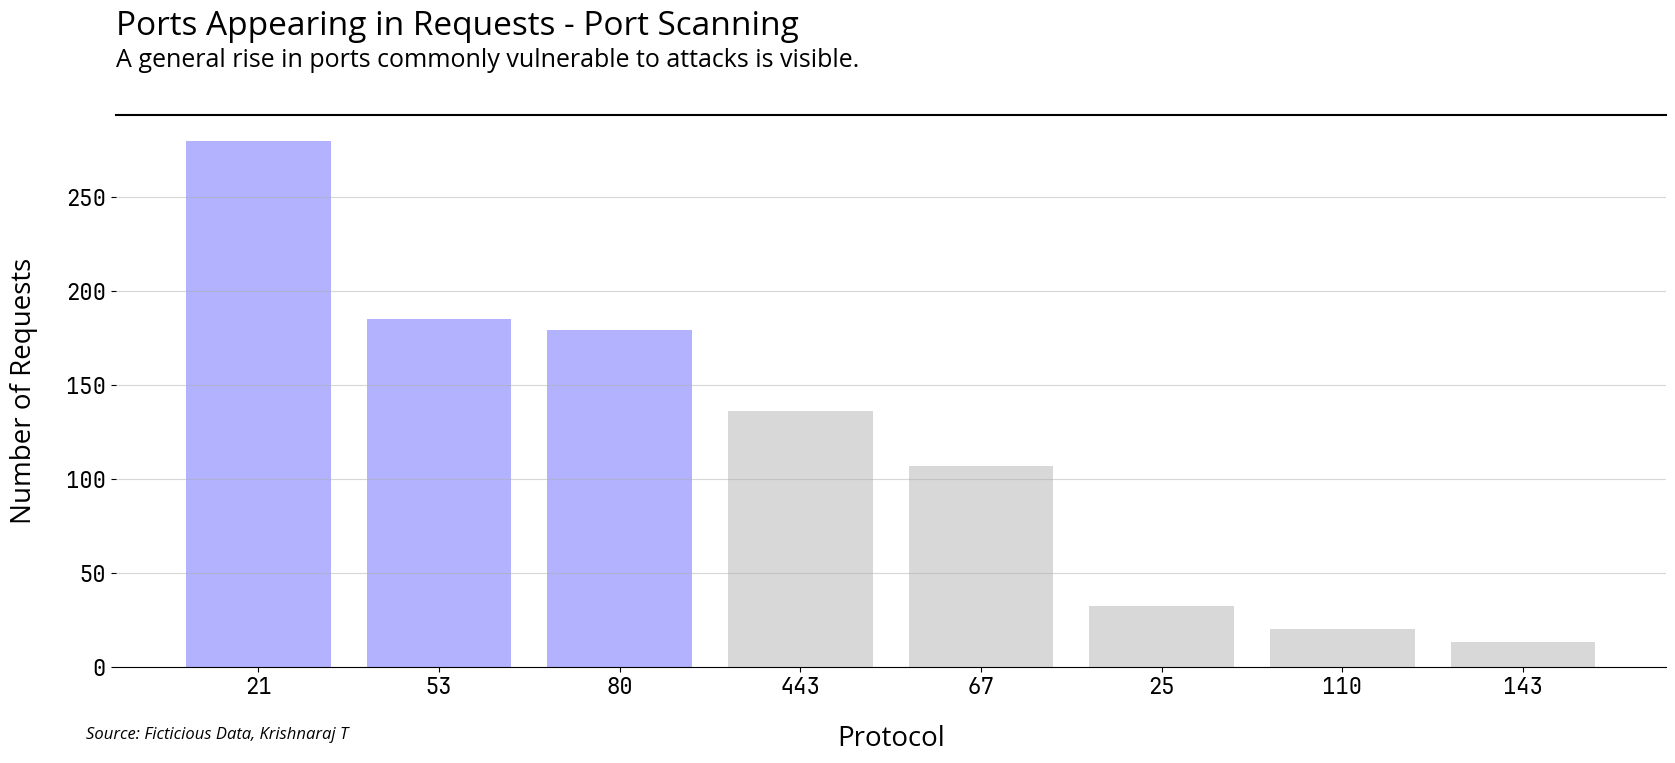

In [29]:

# set the color of the first rectangle to pink and the color of the other rectangles to gray
colors = ['blue'] * 3 + ['gray'] * (len(port_counts) - 3)

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'Ports Appearing in Requests - Port Scanning'
subtitle ='A general rise in ports commonly vulnerable to attacks is visible.'

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# changing space
plt.subplots_adjust(top=0.8, wspace=0.3)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.5)
# plt.grid(axis='x', alpha=0.5)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Total Requests Made over timespan', fontsize=20, fontname="Open Sans", labelpad=20)
plt.ylabel('Website', fontsize=20, fontname="Open Sans", labelpad=20)


# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

plt.bar(port_counts.index, port_counts.values, color=colors, alpha=0.3)

# set the title and axis labels
# ax.set_title('Protocols Used to Make Requests')
ax.set_xlabel('Protocol')
ax.set_ylabel('Number of Requests')

# set the x-axis tick labels to be rotated for better readability
# plt.xticks(rotation=45)


# footnote
footnote = "Source: Ficticious Data, Krishnaraj T"
plt.text(
    x = 0.11,
    y = 0.02,
    s = footnote,
    fontname = 'Open Sans',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)


/tmp/ipykernel_1371293/3533643962.py:43: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(dates.index, dates.values, color='red', marker='o', linestyle='dashed', linewidth=1, markersize=5)


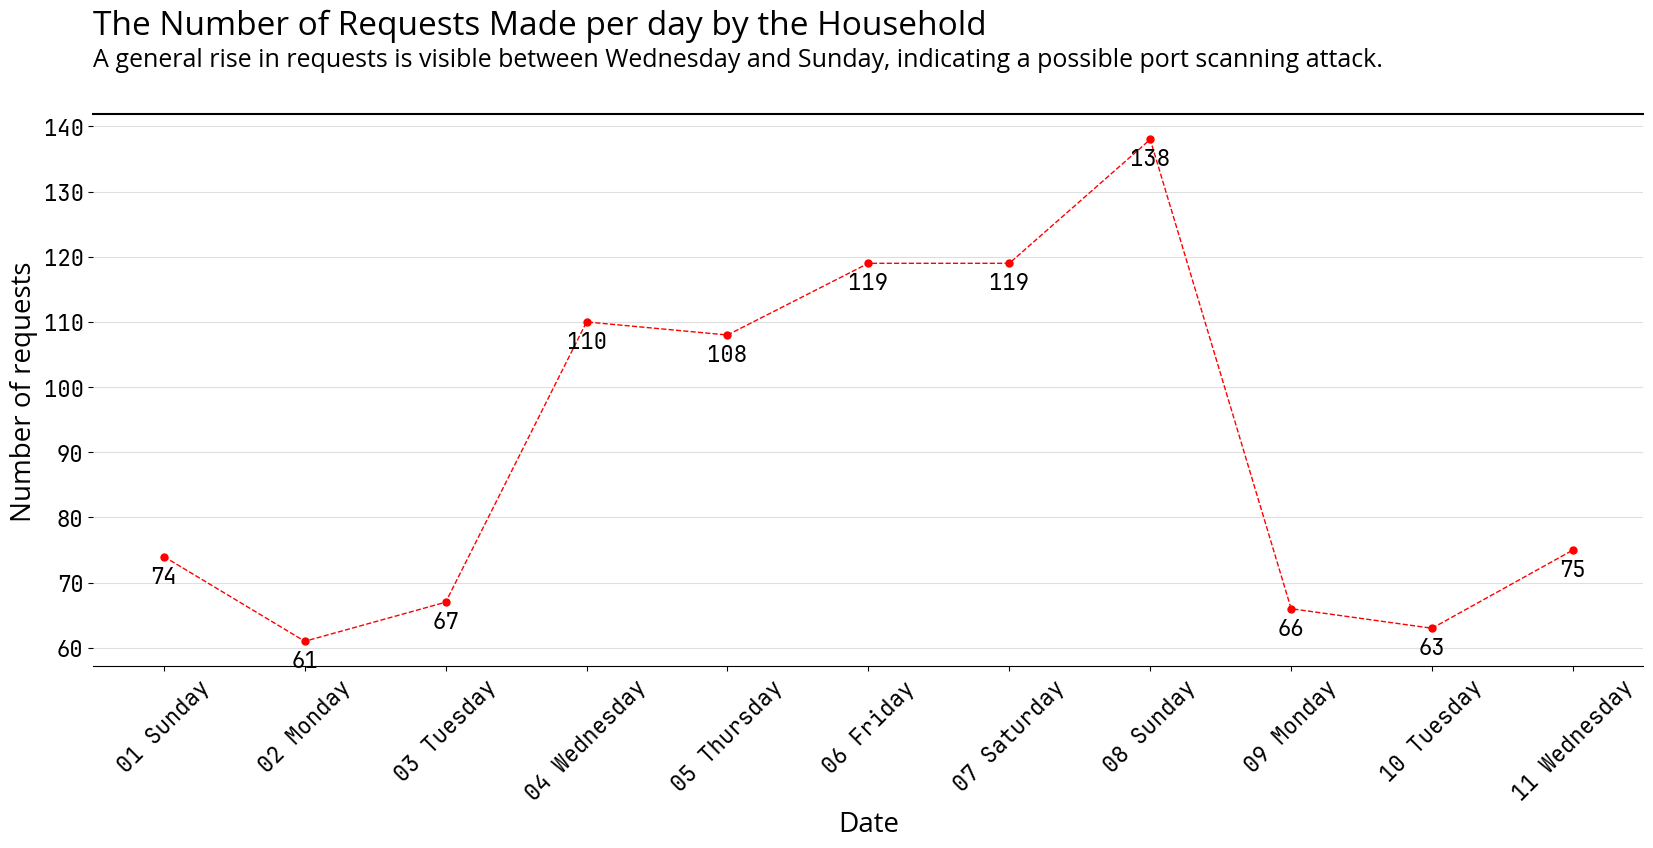

In [30]:
# let us plot the number of requests per day
port_scanning_db['Time'] = pd.to_datetime(port_scanning_db['Time'])
port_scanning_db['Date'] = port_scanning_db['Time'].dt.date

# sort data by date
port_scanning_db = port_scanning_db.sort_values(by=['Date'])

# now let us plot the number of requests per day
dates = port_scanning_db['Date'].value_counts()

# sorting dates
dates = dates.sort_index()

# creating the plot. 
fig, ax = plt.subplots(figsize=(20, 8))

# informative title + subtitle
title = 'The Number of Requests Made per day by the Household'
subtitle = 'A general rise in requests is visible between Wednesday and Sunday, indicating a possible port scanning attack.'

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title, fontname="Open Sans",
    fontsize = 24,ha='left',transform = fig.transFigure
)

plt.text(
    x = 0.125,y = 0.86,s = subtitle, fontname="Open Sans",
    fontsize = 18,ha = 'left',transform = fig.transFigure
)

# line between titles and chart
plt.gca().plot(
    [0.125, .9], # x co-ords
    [.80, .80], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# plotting as a time series
plt.plot_date(dates.index, dates.values, color='red', marker='o', linestyle='dashed', linewidth=1, markersize=5)

# also put labels on the markers a little over the markers for visibility
for i in range(len(dates)):
    plt.text(dates.index[i], dates.values[i]-3, dates.values[i], ha='center', va='center', color='black', fontsize=16)

# set the size of the tick labels and axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Date', fontsize=20, fontname="Open Sans")
plt.ylabel('Number of requests', fontsize=20, fontname="Open Sans")

# change space on top of chart we are actually adjusting the scale of the plot as well. 
plt.subplots_adjust(top=0.8, wspace=0.3)

# set the font size of the tick labels
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(16)

# tilt the x-axis labels by 45 degrees
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.4)
# plt.grid(axis='x', alpha=0.2)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# customize the tick labels
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %A'))

plt.show()